In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import sklearn
from res_tool import plot_main, plot_clustered_kuramoto
from scipy import stats
from itertools import combinations  # 用于生成两两组合

## 数据生成

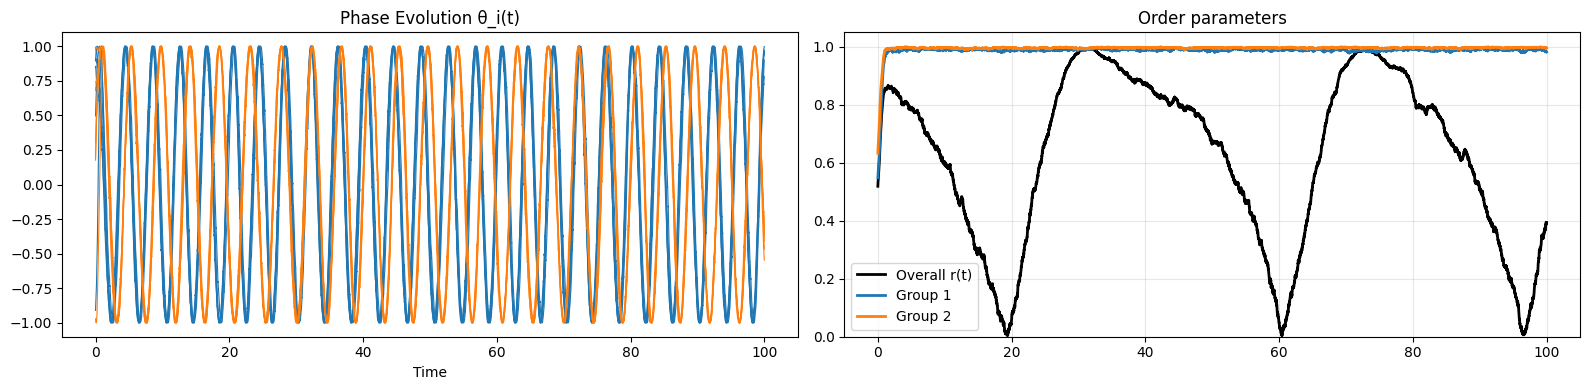

In [4]:
N=12
X_embed, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=5,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=100
)

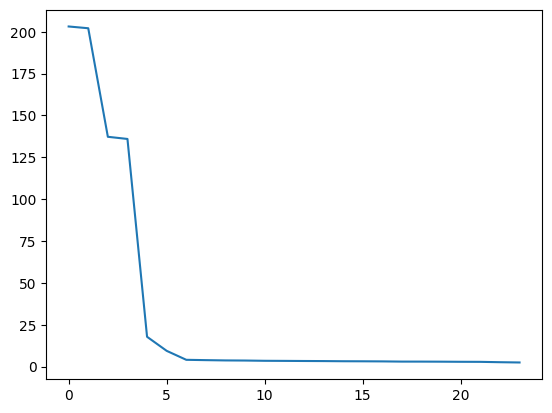

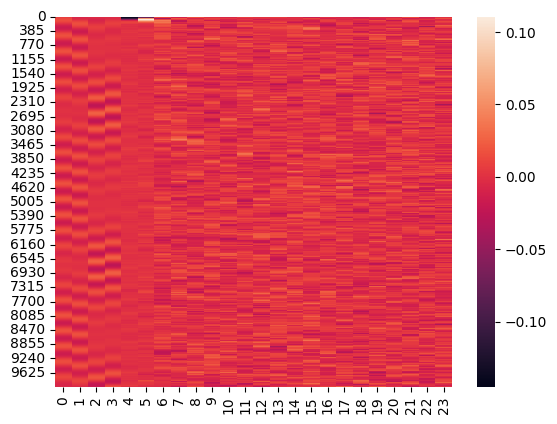

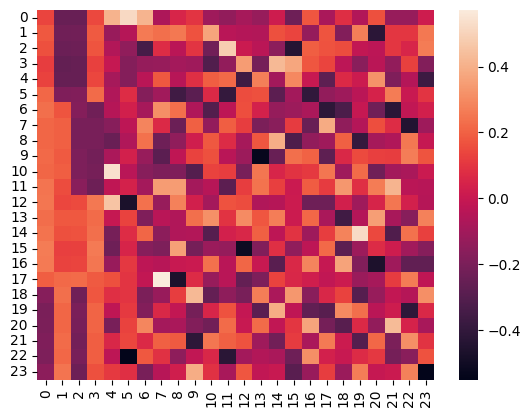

In [5]:
tsvd = pykoop.Tsvd() #truncation='rank',truncation_param=8
tsvd.fit(X_embed)
plt.plot(tsvd.singular_values_)
plt.show()
sns.heatmap(tsvd.left_singular_vectors_)
plt.show()
sns.heatmap(tsvd.right_singular_vectors_)
plt.show()

## Koopman 拟合

In [6]:
#多项式函数
kppl = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),#,truncation_param=20
)
# Fit the pipeline
kppl.fit(
    X_embed,
    n_inputs=0
)
errorpl = -kppl.score(X_embed)
errorpl

0.08168566465241411

In [7]:
# 径向基函数
kprbf = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=24)),shape=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)
# Fit the pipeline
kprbf.fit(
    X_embed,
    n_inputs=0
)
errorrbf = -kprbf.score(X_embed)
errorrbf

0.027400090182123582

In [8]:
#kernal，随机傅立叶表征
kpker = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=24,
                random_state=10,
            )),
    )],
    regressor=pykoop.Edmd(alpha=0.5),
)

kpker.fit(
    X_embed,
    n_inputs=0
)
errorker = -kpker.score(X_embed)
errorker

0.07930942051545412

In [9]:
#延迟嵌入，Hankel
kphan = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kphan.fit(
    X_embed,
    n_inputs=0
)
errorhan = -kphan.score(X_embed)
errorhan


0.08357105909849365

## Res

总特征值数量: 24
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [0, 1, 2, 3])
虚假特征值数量 (res > 0.01): 20
残差RES的范围：0.014702 ~ 0.240933


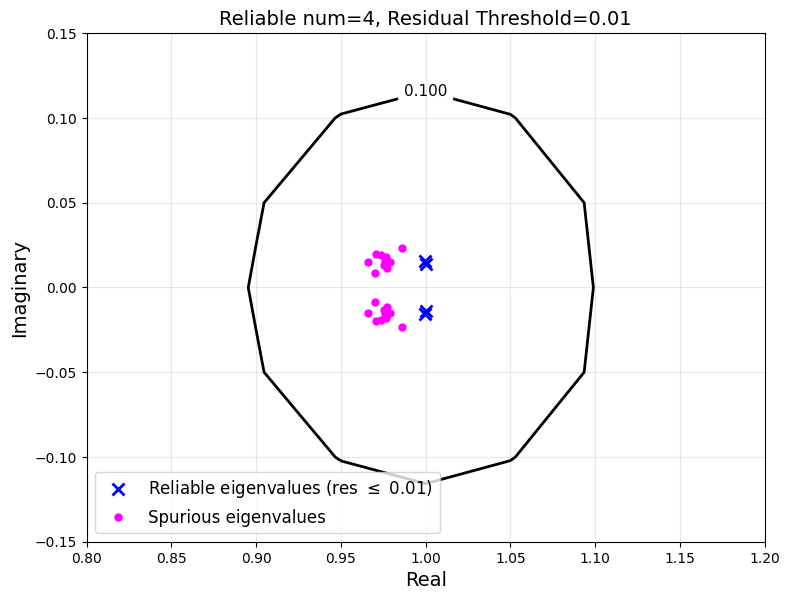

In [10]:
eigenvaluespl, residualspl, reliable_indicespl = plot_main(kppl, X_embed)

总特征值数量: 48
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [24, 25, 26, 27])
虚假特征值数量 (res > 0.01): 44
残差RES的范围：0.014698 ~ 0.240927


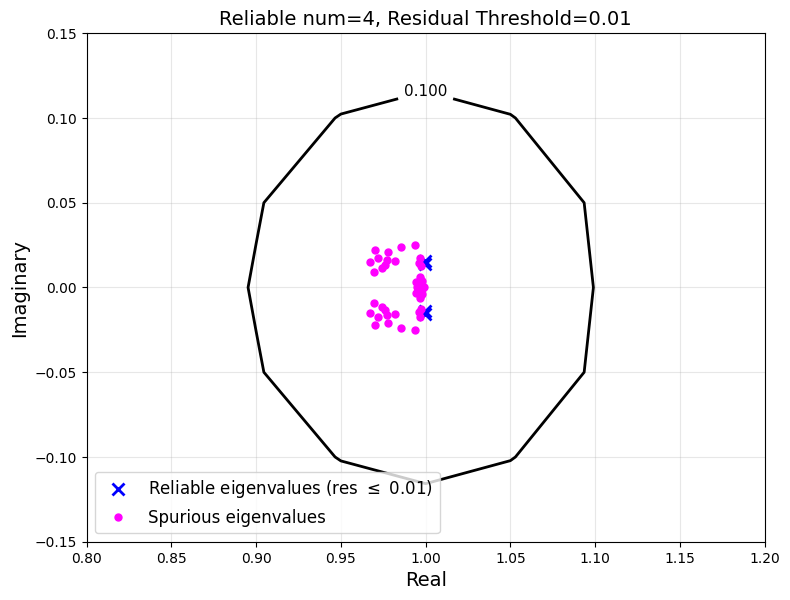

In [11]:
eigenvaluesrbf, residualsrbf, reliable_indicesrbf = plot_main(kprbf, X_embed)

总特征值数量: 48
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [30, 31, 32, 33])
虚假特征值数量 (res > 0.01): 44
残差RES的范围：0.014695 ~ 0.240916


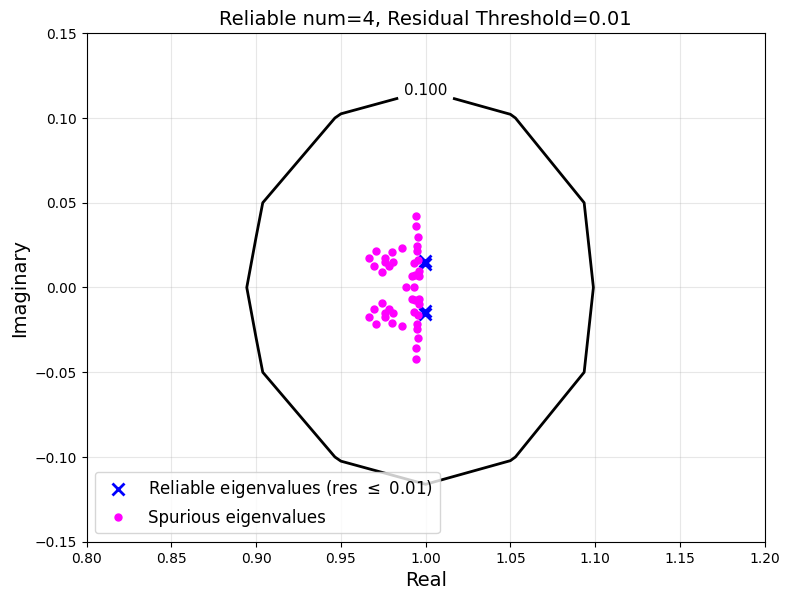

In [12]:
eigenvaluesker, residualsker, reliable_indicesker = plot_main(kpker, X_embed)

总特征值数量: 72
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [48, 49, 50, 51])
虚假特征值数量 (res > 0.01): 68
残差RES的范围：0.014258 ~ 0.240864


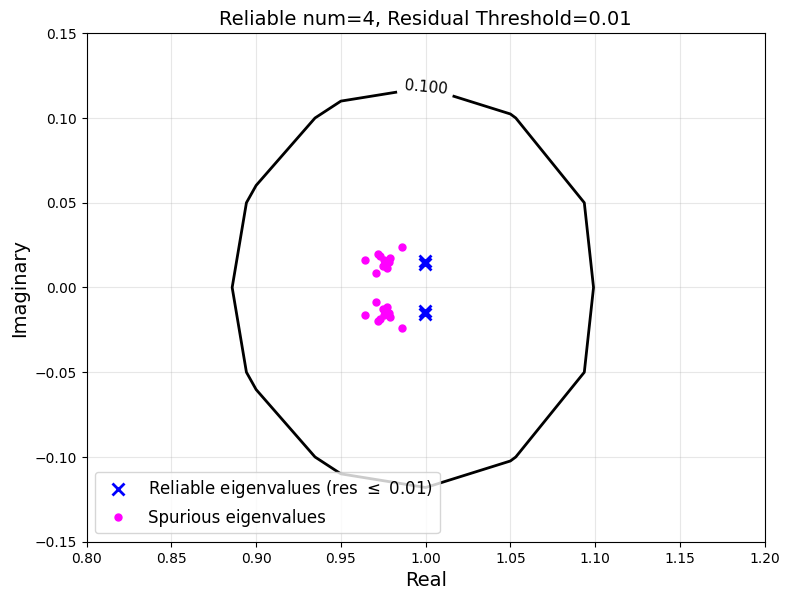

In [13]:
eigenvalueshan, residualshan, reliable_indiceshan = plot_main(kphan, X_embed)

## 多步预测

In [14]:
p_steps = 1000
X_test = X_embed[:p_steps,:]

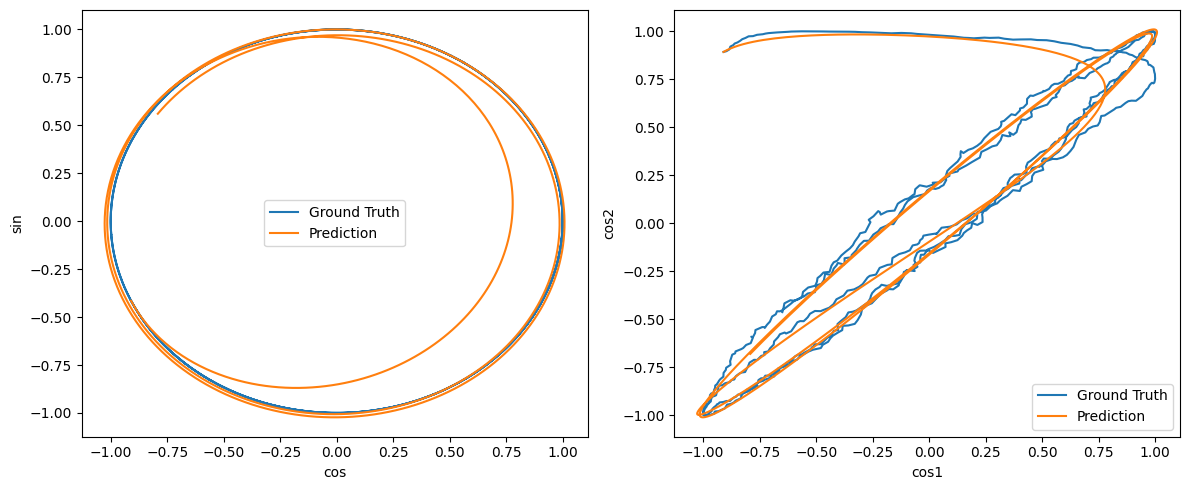

In [15]:
predpl = kppl.predict_trajectory(X_test,None)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], X_test[:, N], label='Ground Truth')
plt.plot(predpl[:, 0], predpl[:, N], label='Prediction')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X_test[:, 0], X_test[:, 1], label='Ground Truth')
plt.plot(predpl[:, 0], predpl[:, 1], label='Prediction')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.tight_layout()
plt.show()

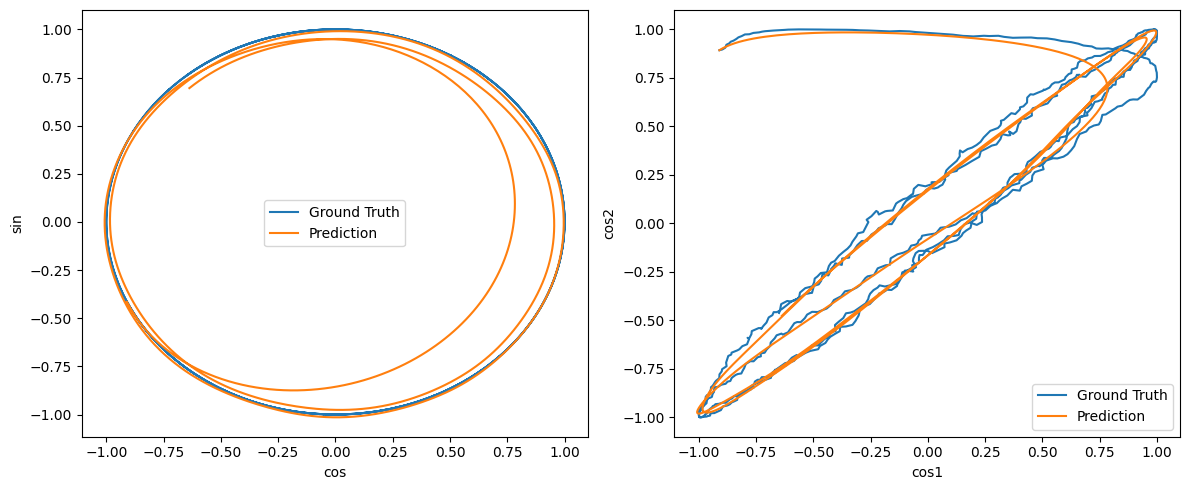

In [16]:
predrbf = kprbf.predict_trajectory(X_test,None)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], X_test[:, N], label='Ground Truth')
plt.plot(predrbf[:, 0], predrbf[:, N], label='Prediction')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X_test[:, 0], X_test[:, 1], label='Ground Truth')
plt.plot(predrbf[:, 0], predrbf[:, 1], label='Prediction')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.tight_layout()
plt.show()

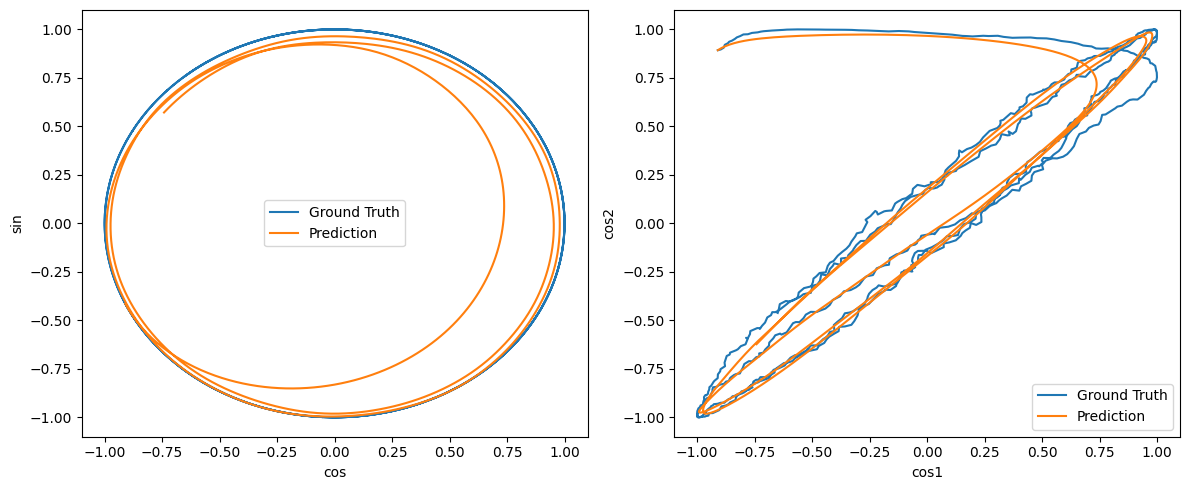

In [17]:
predker = kpker.predict_trajectory(X_test,None)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], X_test[:, N], label='Ground Truth')
plt.plot(predker[:, 0], predker[:, N], label='Prediction')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X_test[:, 0], X_test[:, 1], label='Ground Truth')
plt.plot(predker[:, 0], predker[:, 1], label='Prediction')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.tight_layout()
plt.show()

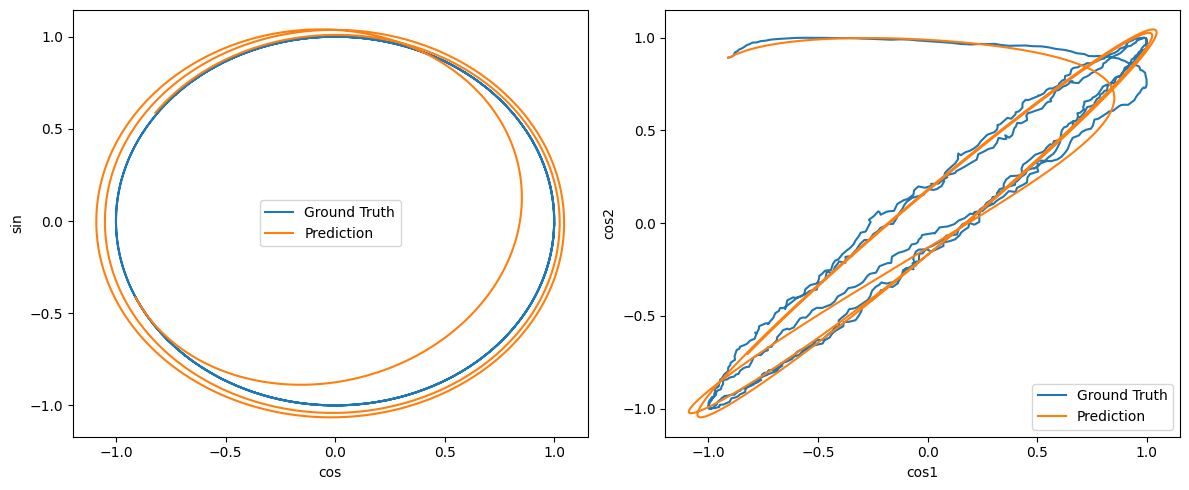

In [18]:
predhan = kphan.predict_trajectory(X_test,None)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], X_test[:, N], label='Ground Truth')
plt.plot(predhan[:, 0], predhan[:, N], label='Prediction')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X_test[:, 0], X_test[:, 1], label='Ground Truth')
plt.plot(predhan[:, 0], predhan[:, 1], label='Prediction')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.tight_layout()
plt.show()

## 特征谱与SVD分析

### 多项式 pl

(<Figure size 640x480 with 2 Axes>, <Axes: >)

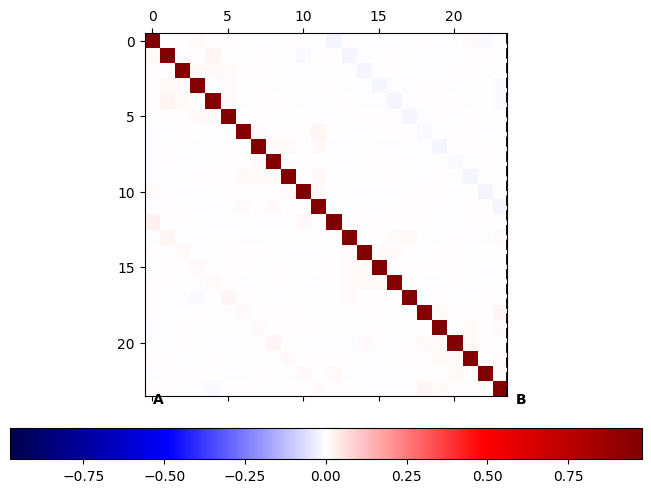

In [19]:
kppl.regressor_.plot_koopman_matrix()

(24, 24)


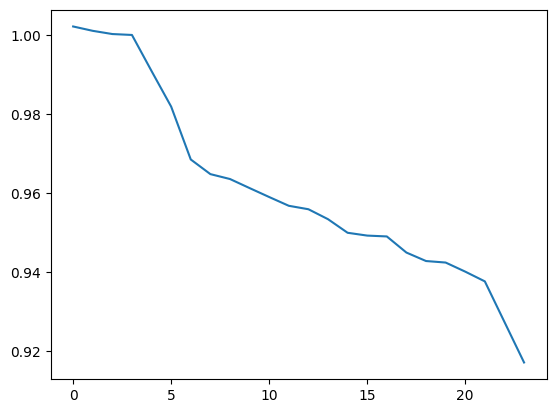

In [20]:
Apl = kppl.regressor_.coef_
print(Apl.shape)
Upl,Spl,Vpl = np.linalg.svd(Apl)
plt.figure()
plt.plot(Spl)
plt.show()

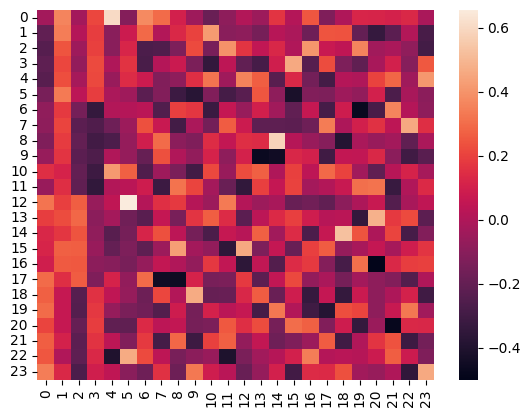

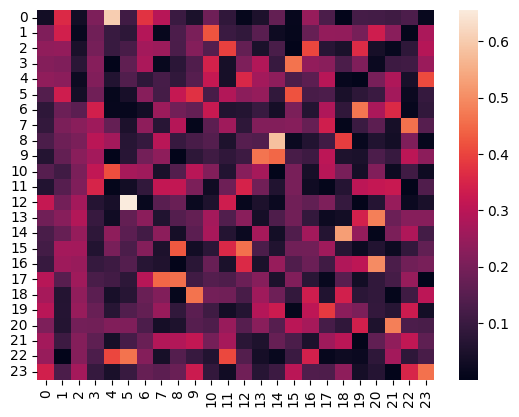

In [21]:
Upl_abs = np.abs(Upl)
plt.figure()
sns.heatmap(np.real(Upl))
plt.show()
plt.figure()
sns.heatmap(Upl_abs)
plt.show()

In [22]:
eig_valpl, left_vecspl = np.linalg.eig(Apl.T)
eig_valpl, righ_vecspl = np.linalg.eig(Apl)
phipl = left_vecspl @ kppl.lift(X_embed).T

phi_to_plotpl1 = phipl[0, :] # 选择第一个特征函数
t = np.arange(0, 100, 0.01)

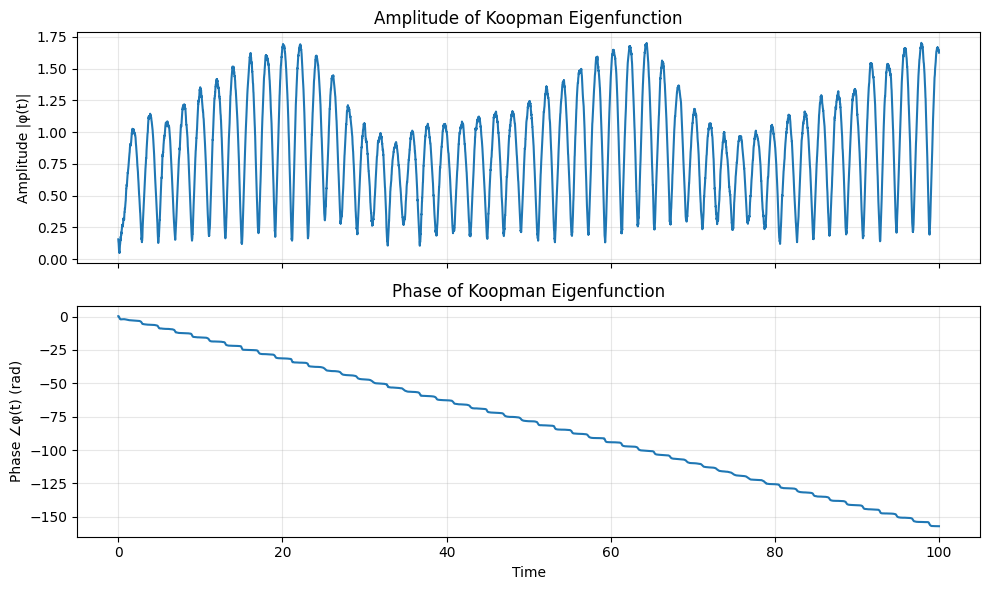

In [23]:
# 计算幅值和相位
amplitudepl = np.abs(phi_to_plotpl1)
phasepl = np.angle(phi_to_plotpl1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t, amplitudepl)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)
# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t, np.unwrap(phasepl)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

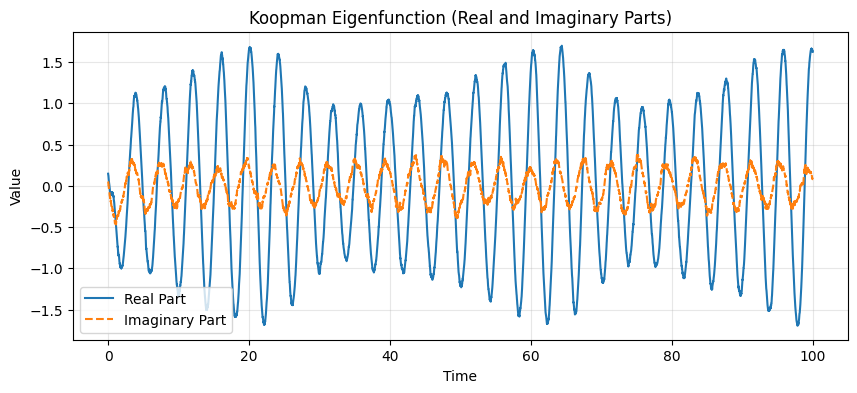

In [24]:
# 绘制特征函数
plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t, np.real(phi_to_plotpl1), label="Real Part")
plt.plot(t, np.imag(phi_to_plotpl1), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

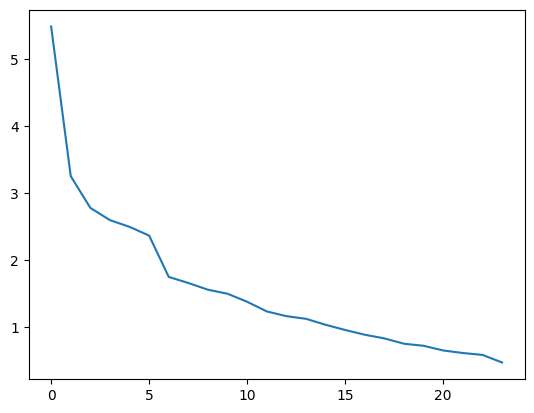

In [25]:
A_pl = Apl @ np.linalg.inv(left_vecspl)
U_pl,S_pl,V_pl = np.linalg.svd(A_pl)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S_pl)
plt.show()

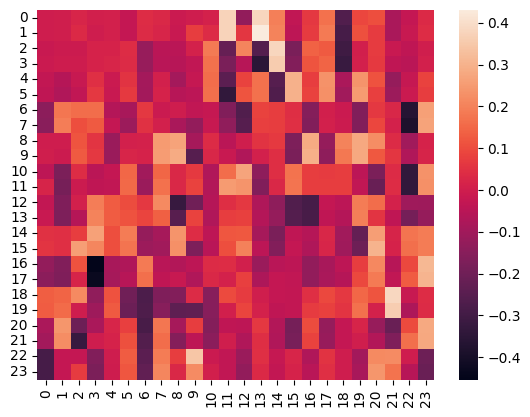

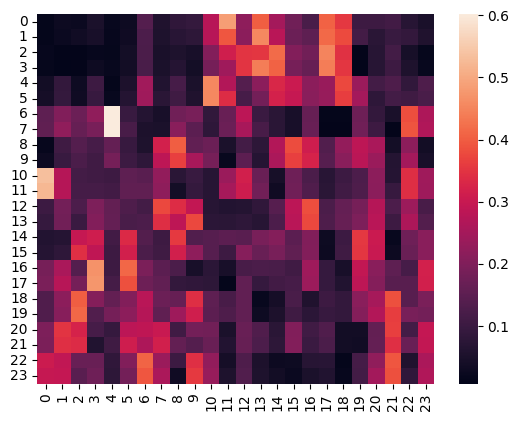

In [26]:
U_pl_abs = np.abs(U_pl)
plt.figure()
sns.heatmap(np.real(U_pl))
plt.show()
plt.figure()
sns.heatmap(U_pl_abs)
plt.show()

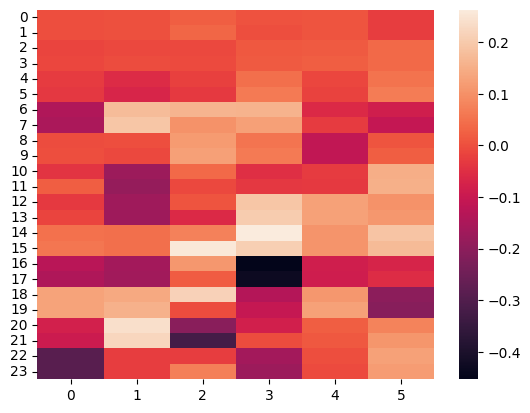

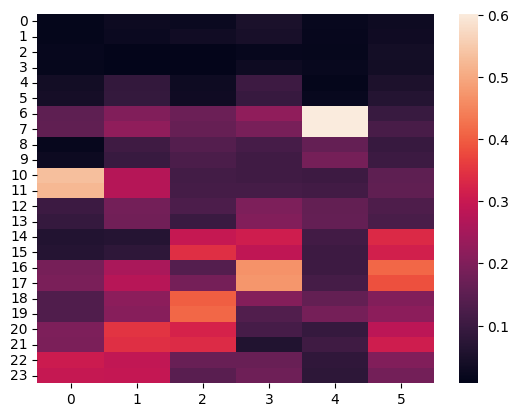

In [27]:
plt.figure()
sns.heatmap(np.real(U_pl[:,:6]))
plt.show()
plt.figure()
sns.heatmap(U_pl_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

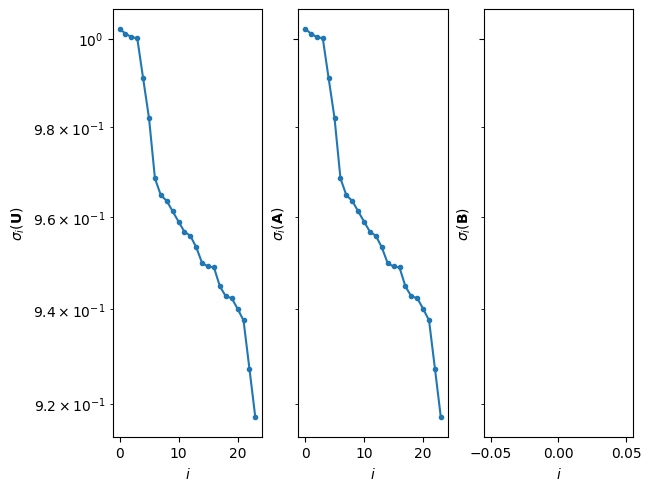

In [28]:
kppl.regressor_.plot_svd()

### 径向基RBF

(<Figure size 640x480 with 2 Axes>, <Axes: >)

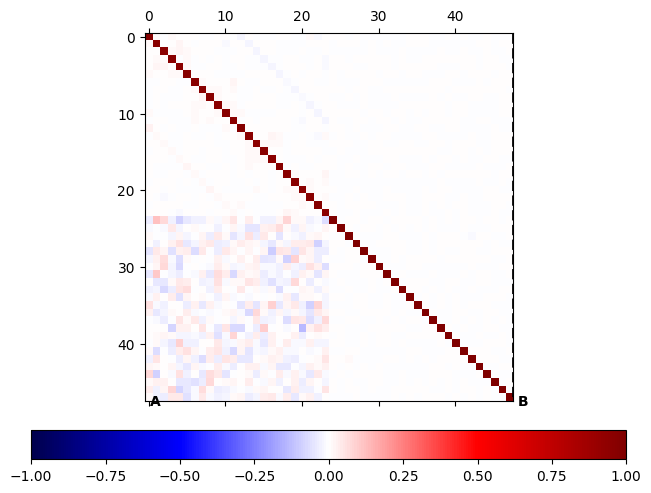

In [29]:
kprbf.regressor_.plot_koopman_matrix()

(48, 48)


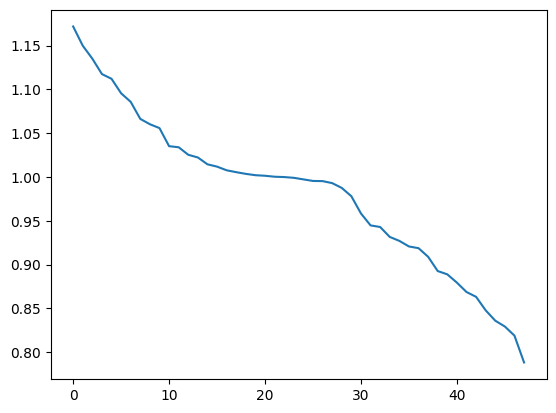

In [30]:
Arbf = kprbf.regressor_.coef_
print(Arbf.shape)
Urbf,Srbf,Vrbf = np.linalg.svd(Arbf)
plt.figure()
plt.plot(Srbf)
plt.show()

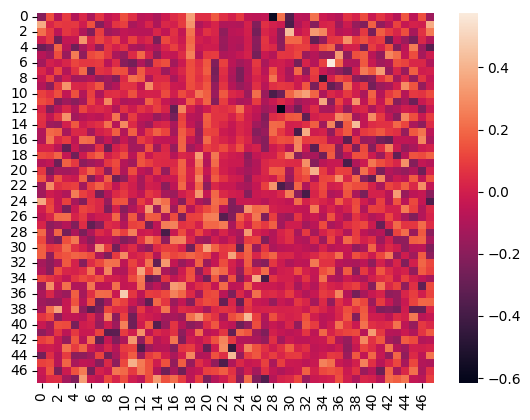

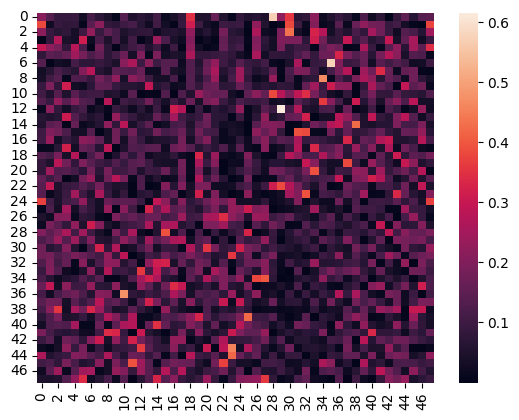

In [31]:
Urbf_abs = np.abs(Urbf)
plt.figure()
sns.heatmap(np.real(Urbf))
plt.show()
plt.figure()
sns.heatmap(Urbf_abs)
plt.show()

In [32]:
eig_valrbf, left_vecsrbf = np.linalg.eig(Arbf.T)
eig_valrbf, righ_vecsrbf = np.linalg.eig(Arbf)
phirbf = left_vecsrbf @ kprbf.lift(X_embed).T

phi_to_plotrbf1 = phirbf[0, :] # 选择第一个特征函数

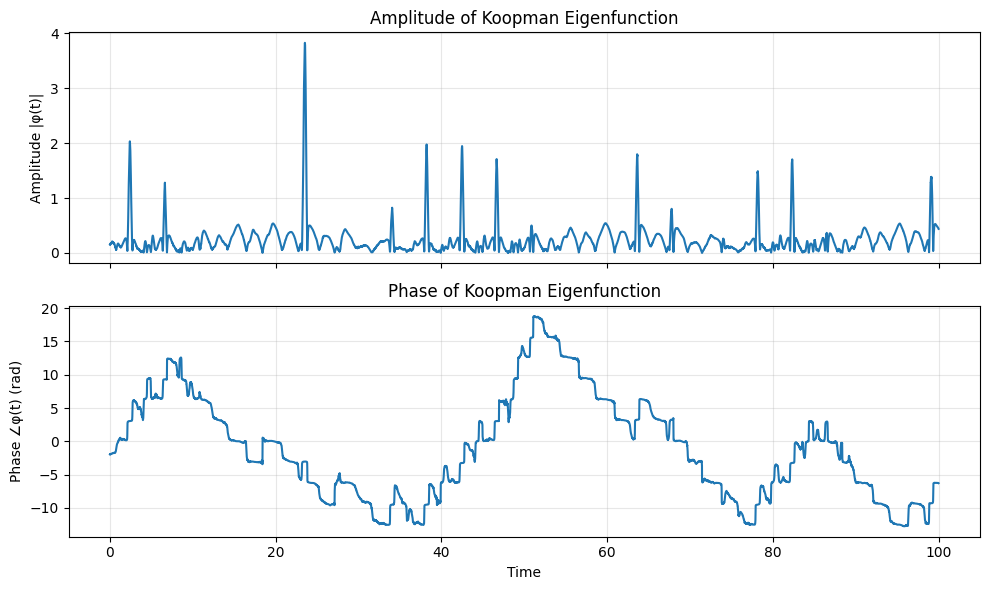

In [33]:
# 计算幅值和相位
amplituderbf = np.abs(phi_to_plotrbf1)
phaserbf = np.angle(phi_to_plotrbf1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t, amplituderbf)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)
# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t, np.unwrap(phaserbf)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

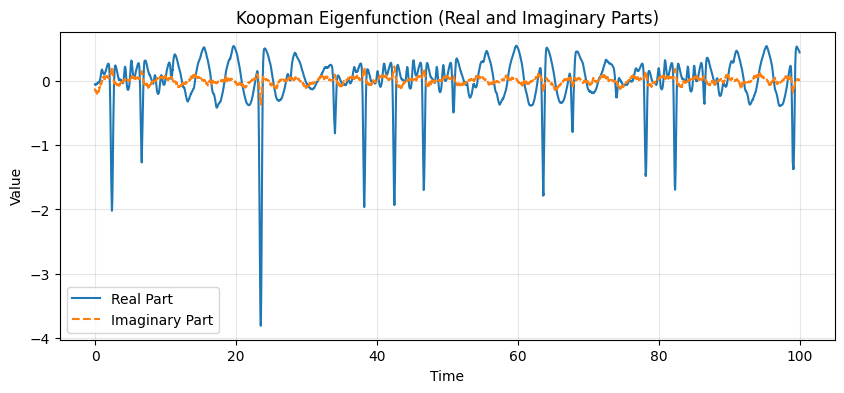

In [34]:
# 绘制特征函数
plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t, np.real(phi_to_plotrbf1), label="Real Part")
plt.plot(t, np.imag(phi_to_plotrbf1), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

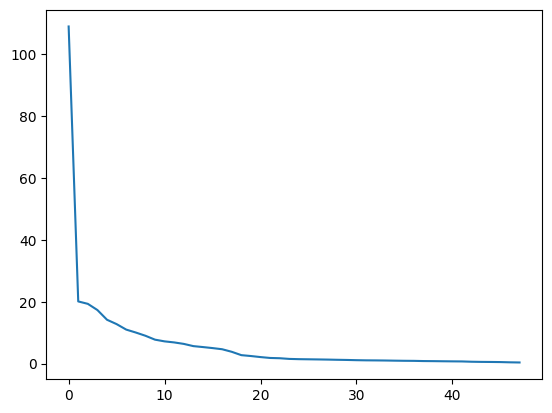

In [35]:
A_rbf = Arbf @ np.linalg.inv(left_vecsrbf)
U_rbf,S_rbf,V_rbf = np.linalg.svd(A_rbf)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S_rbf)
plt.show()

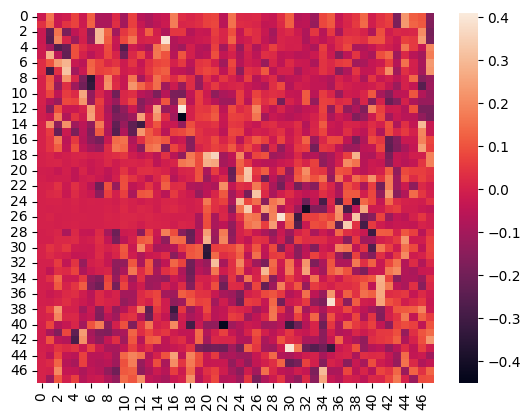

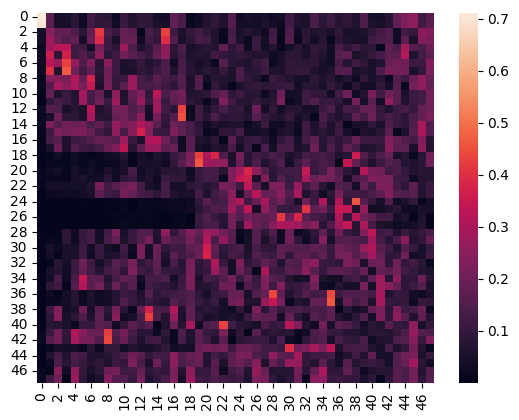

In [36]:
U_rbf_abs = np.abs(U_rbf)
plt.figure()
sns.heatmap(np.real(U_rbf))
plt.show()
plt.figure()
sns.heatmap(U_rbf_abs)
plt.show()

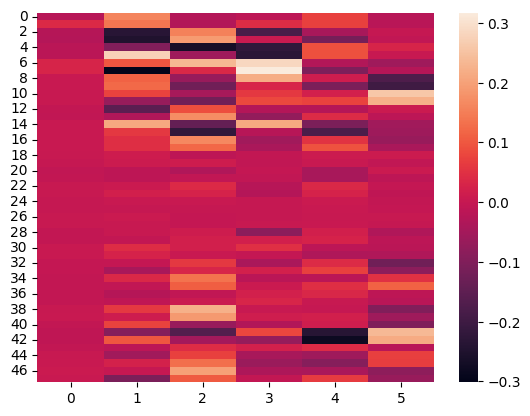

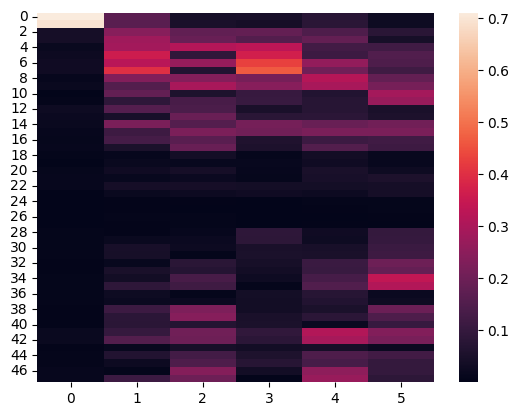

In [37]:
plt.figure()
sns.heatmap(np.real(U_rbf[:,:6]))
plt.show()
plt.figure()
sns.heatmap(U_rbf_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

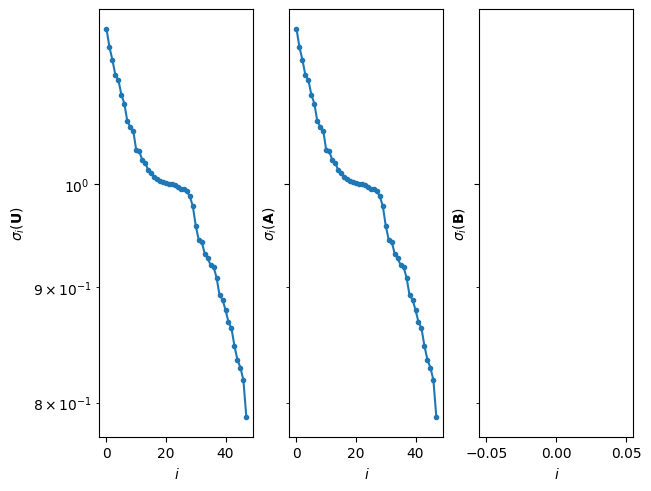

In [38]:
kprbf.regressor_.plot_svd()

### 高斯基 ker

(<Figure size 640x480 with 2 Axes>, <Axes: >)

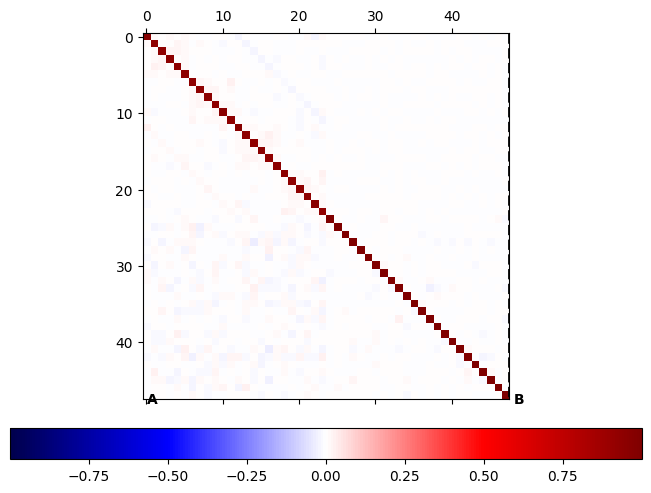

In [39]:
kpker.regressor_.plot_koopman_matrix()

(48, 48)


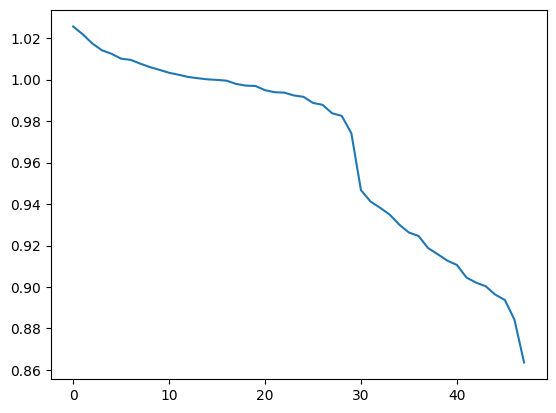

In [40]:
Aker = kpker.regressor_.coef_
print(Aker.shape)
Uker,Sker,Vker = np.linalg.svd(Aker)
plt.figure()
plt.plot(Sker)
plt.show()

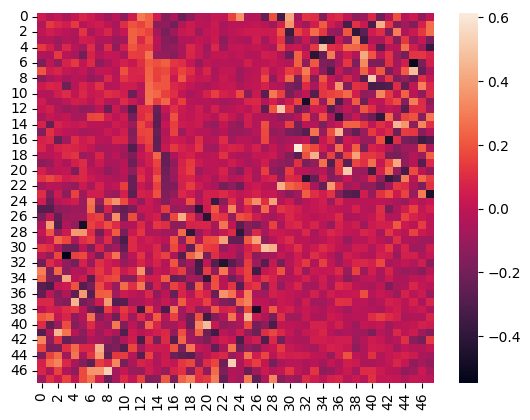

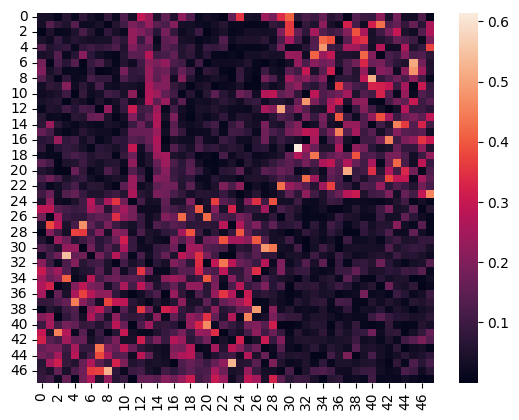

In [41]:
Uker_abs = np.abs(Uker)
plt.figure()
sns.heatmap(np.real(Uker))
plt.show()
plt.figure()
sns.heatmap(Uker_abs)
plt.show()

In [42]:
eig_valker, left_vecsker = np.linalg.eig(Aker.T)
eig_valker, righ_vecsker = np.linalg.eig(Aker)
phiker = left_vecsker @ kpker.lift(X_embed).T

phi_to_plotker1 = phiker[0, :] # 选择第一个特征函数

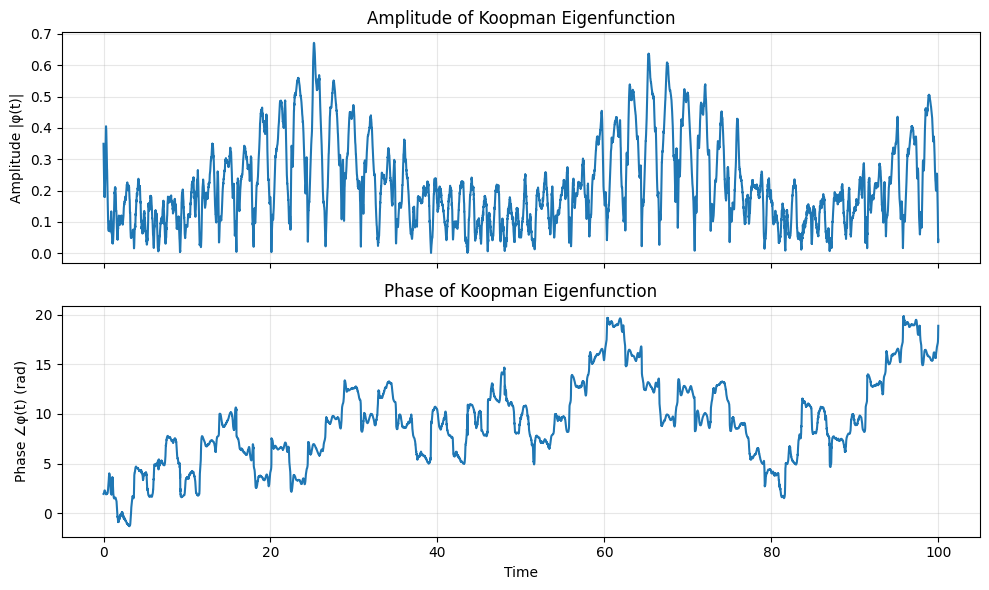

In [43]:
# 计算幅值和相位
amplitudeker = np.abs(phi_to_plotker1)
phaseker = np.angle(phi_to_plotker1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t, amplitudeker)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)
# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t, np.unwrap(phaseker)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

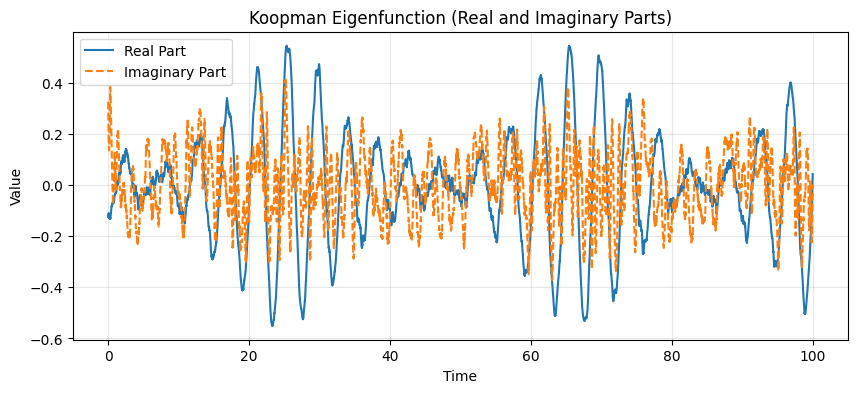

In [44]:
# 绘制特征函数
plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t, np.real(phi_to_plotker1), label="Real Part")
plt.plot(t, np.imag(phi_to_plotker1), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

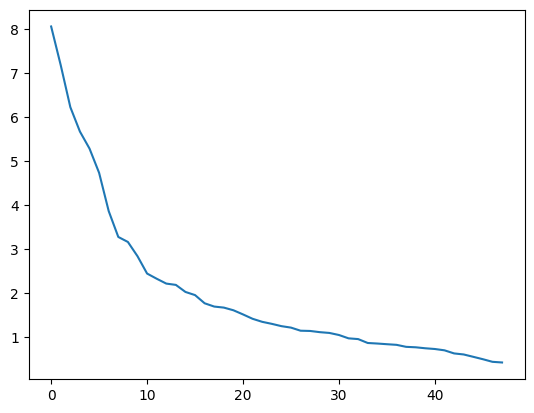

In [45]:
A_ker = Aker @ np.linalg.inv(left_vecsker)
U_ker,S_ker,V_ker = np.linalg.svd(A_ker)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S_ker)
plt.show()

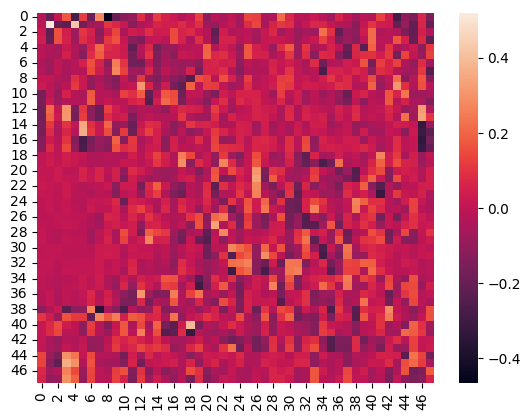

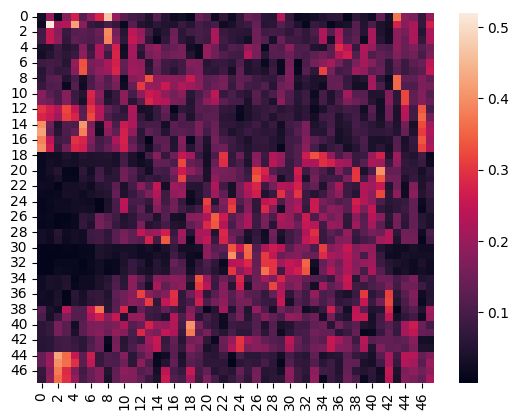

In [46]:
U_ker_abs = np.abs(U_ker)
plt.figure()
sns.heatmap(np.real(U_ker))
plt.show()
plt.figure()
sns.heatmap(U_ker_abs)
plt.show()

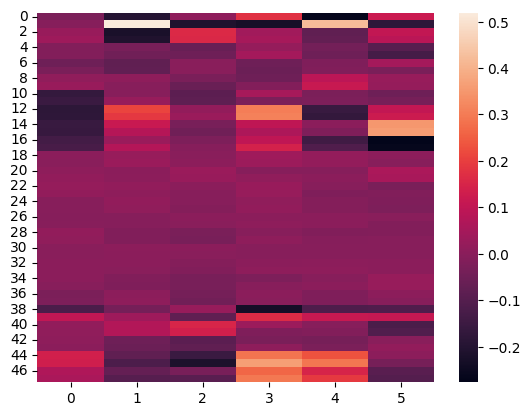

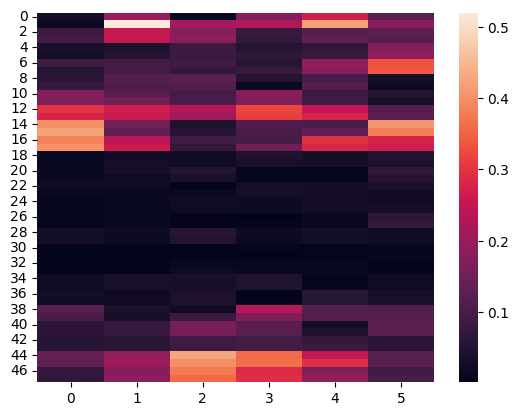

In [47]:
plt.figure()
sns.heatmap(np.real(U_ker[:,:6]))
plt.show()
plt.figure()
sns.heatmap(U_ker_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

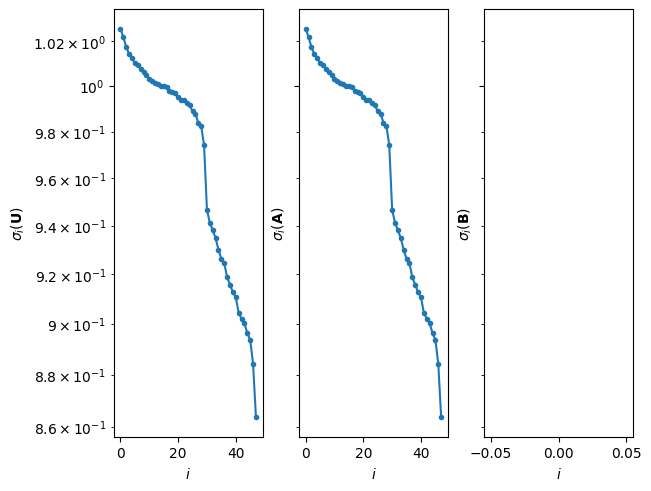

In [48]:
kpker.regressor_.plot_svd()

### 时间延迟 han

(<Figure size 640x480 with 2 Axes>, <Axes: >)

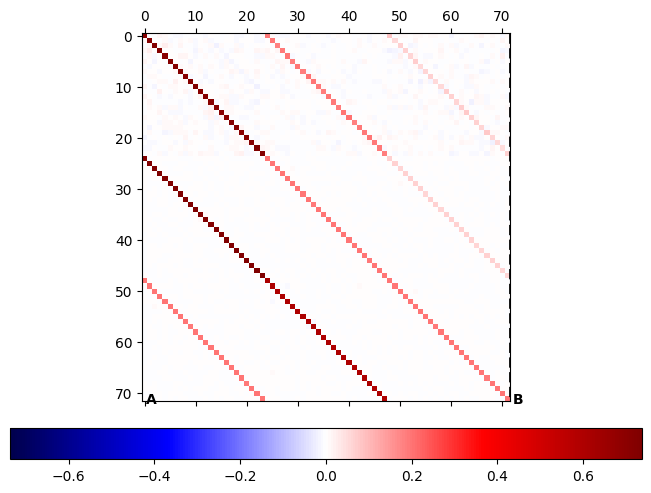

In [49]:
kphan.regressor_.plot_koopman_matrix()

(72, 72)


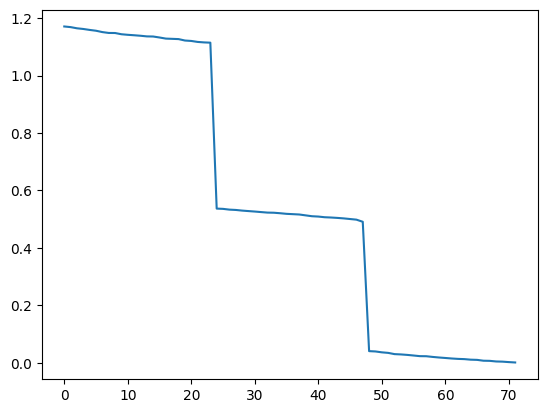

In [50]:
Ahan = kphan.regressor_.coef_
print(Ahan.shape)
Uhan,Shan,Vhan = np.linalg.svd(Ahan)
plt.figure()
plt.plot(Shan)
plt.show()

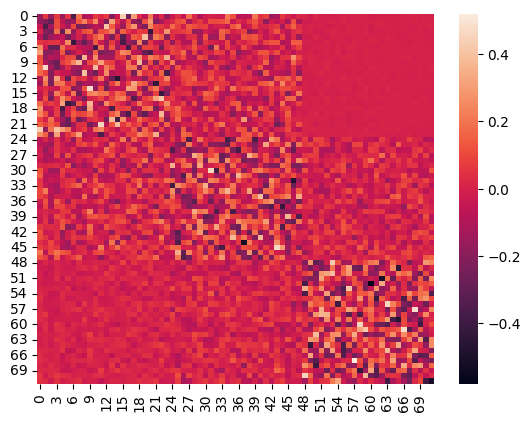

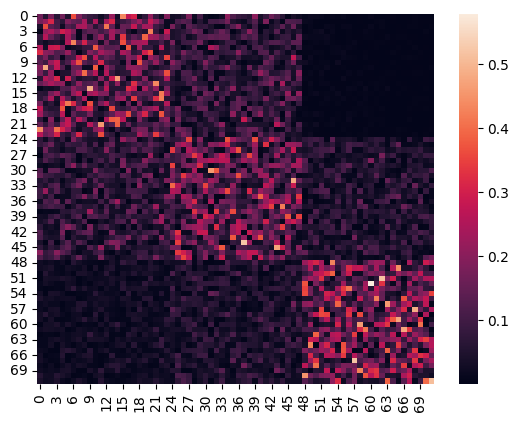

In [51]:
Uhan_abs = np.abs(Uhan)
plt.figure()
sns.heatmap(np.real(Uhan))
plt.show()
plt.figure()
sns.heatmap(Uhan_abs)
plt.show()

In [52]:
eig_valhan, left_vecshan = np.linalg.eig(Ahan.T)
eig_valhan, righ_vecshan = np.linalg.eig(Ahan)
phihan = left_vecshan @ kphan.lift(X_embed).T

phi_to_plothan1 = phihan[0, :] # 选择第一个特征函数

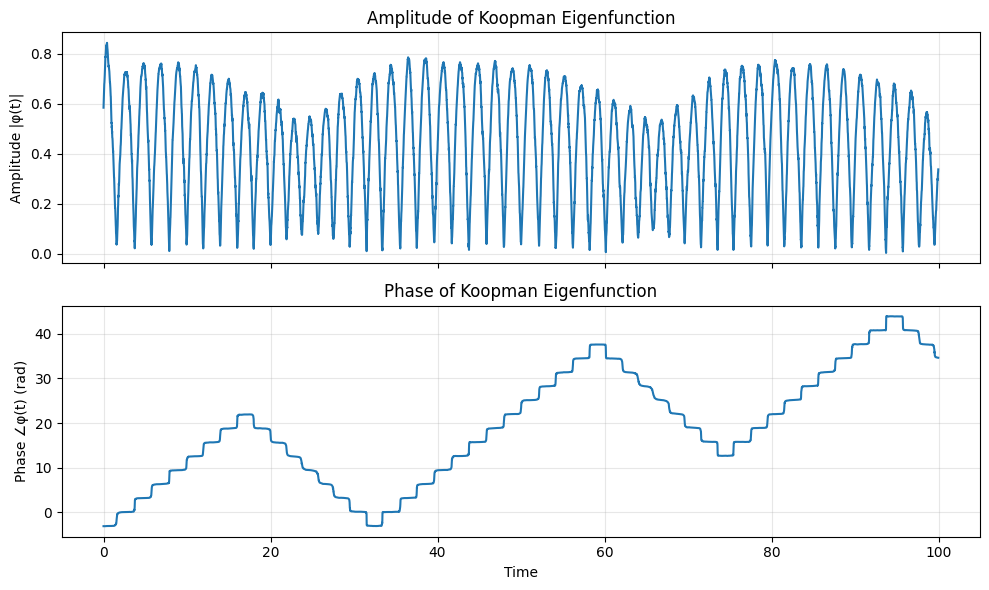

In [53]:
# 计算幅值和相位
amplitudehan = np.abs(phi_to_plothan1)
phasehan = np.angle(phi_to_plothan1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t[:-2], amplitudehan)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)
# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t[:-2], np.unwrap(phasehan)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

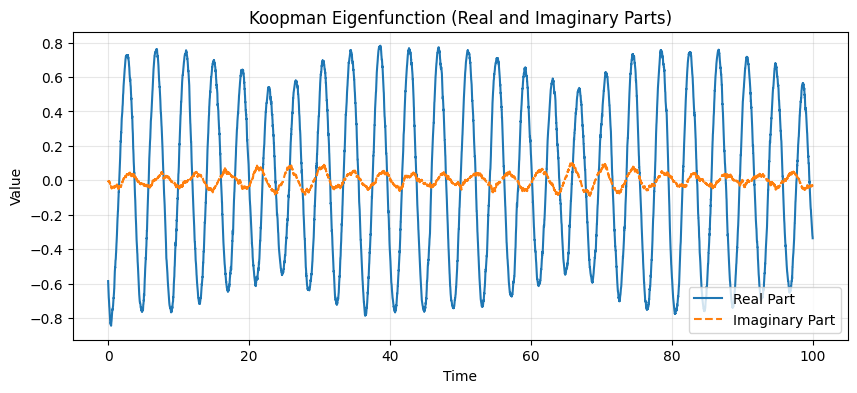

In [54]:
# 绘制特征函数
plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t[:-2], np.real(phi_to_plothan1), label="Real Part")
plt.plot(t[:-2], np.imag(phi_to_plothan1), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

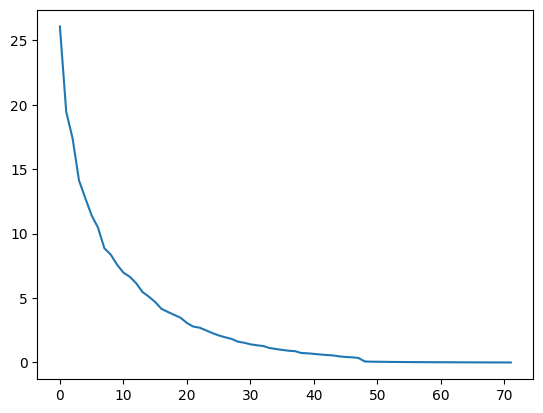

In [55]:
A_han = Ahan @ np.linalg.inv(left_vecshan)
U_han,S_han,V_han = np.linalg.svd(A_han)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S_han)
plt.show()

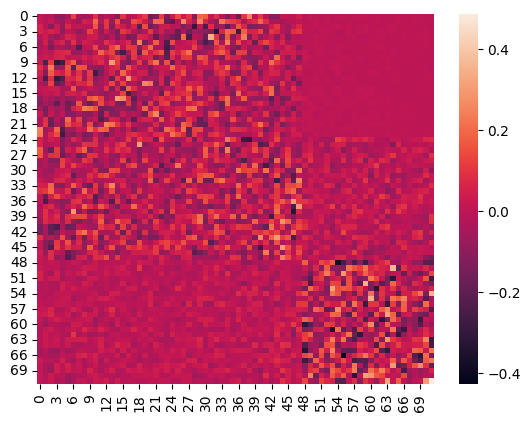

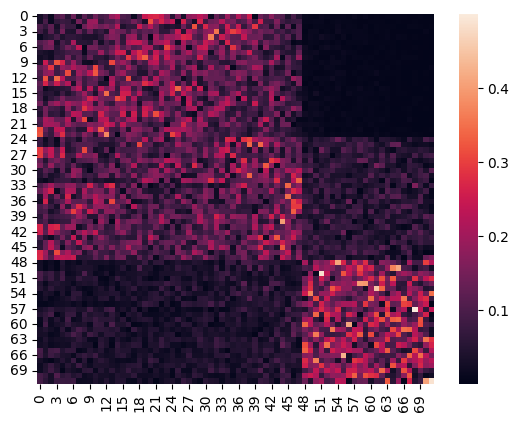

In [56]:
U_han_abs = np.abs(U_han)
plt.figure()
sns.heatmap(np.real(U_han))
plt.show()
plt.figure()
sns.heatmap(U_han_abs)
plt.show()

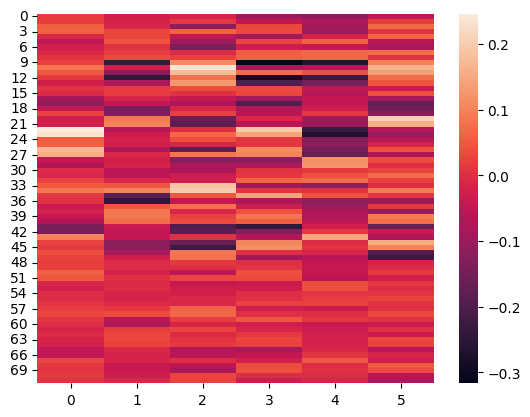

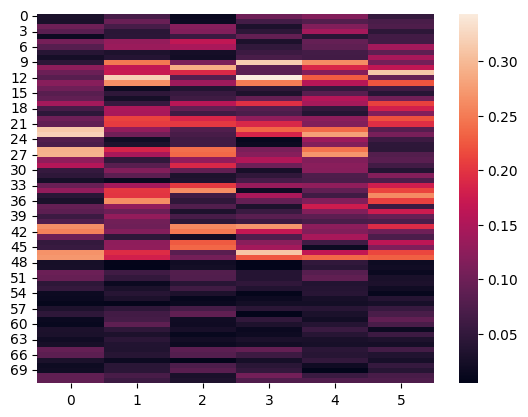

In [57]:
plt.figure()
sns.heatmap(np.real(U_han[:,:6]))
plt.show()
plt.figure()
sns.heatmap(U_han_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

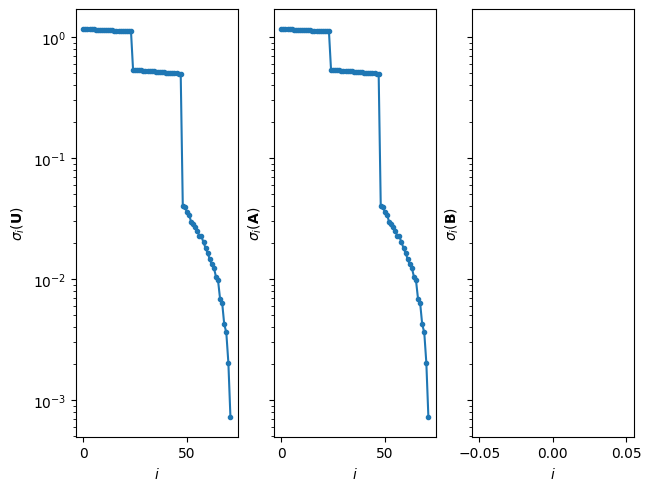

In [58]:
kphan.regressor_.plot_svd()

## 残差总分析

In [73]:
residualspl = np.array(residualspl)
residualspl

array([0.00482873, 0.00482873, 0.00466569, 0.00466569, 0.0653847 ,
       0.0653847 , 0.24173701, 0.24173701, 0.23388109, 0.23388109,
       0.22597856, 0.22597856, 0.19940377, 0.19940377, 0.20948568,
       0.20948568, 0.20117648, 0.20117648, 0.18077688, 0.18077688,
       0.20122032, 0.20122032, 0.17825566, 0.17825566])

In [74]:
residualsrbf = np.array(residualsrbf)
residualsrbf

array([0.23731341, 0.23731341, 0.10653801, 0.10653801, 0.07460632,
       0.07460632, 0.23446089, 0.23446089, 0.20035232, 0.20035232,
       0.20334348, 0.20334348, 0.23079972, 0.23079972, 0.19153306,
       0.19153306, 0.20264956, 0.20264956, 0.15098784, 0.15098784,
       0.15493085, 0.15493085, 0.08085863, 0.08085863, 0.00517021,
       0.00517021, 0.00516263, 0.00516263, 0.0904292 , 0.0904292 ,
       0.07189772, 0.07189772, 0.08262009, 0.08262009, 0.07644132,
       0.07644132, 0.06345486, 0.06345486, 0.10370632, 0.10370632,
       0.10235684, 0.05090962, 0.08190242, 0.08190242, 0.06939193,
       0.06939193, 0.08481704, 0.06599427])

In [75]:
residualsker = np.array(residualsker)
residualsker

array([0.09751609, 0.09751609, 0.0973035 , 0.0973035 , 0.09127377,
       0.09127377, 0.23129403, 0.23129403, 0.22242903, 0.22242903,
       0.21989945, 0.21989945, 0.0944896 , 0.0944896 , 0.06710275,
       0.06710275, 0.18487259, 0.18487259, 0.1804492 , 0.1804492 ,
       0.19341966, 0.19341966, 0.1939375 , 0.1939375 , 0.17948612,
       0.17948612, 0.19106621, 0.19106621, 0.10048261, 0.10048261,
       0.00508219, 0.00508219, 0.00556354, 0.00556354, 0.09380592,
       0.09380592, 0.11468557, 0.11468557, 0.08943137, 0.08943137,
       0.1505609 , 0.11779024, 0.12571901, 0.12571901, 0.10945033,
       0.10945033, 0.0930418 , 0.0930418 ])

In [76]:
residualshan = np.array(residualshan)
residualshan

array([0.97503002, 0.97503002, 0.97542079, 0.97325419, 0.97325419,
       0.97222734, 0.97222734, 0.97776809, 0.97776809, 0.9836481 ,
       0.9836481 , 0.98367493, 0.98367493, 0.98714678, 0.98714678,
       0.99060235, 0.98445974, 0.98445974, 0.99265117, 0.99265117,
       0.9825079 , 0.9825079 , 0.99081227, 0.99081227, 0.99592368,
       0.99592368, 0.97547994, 0.97547994, 0.97487538, 0.97487538,
       0.98180894, 0.98180894, 0.98752966, 0.98752966, 0.97223375,
       0.97223375, 0.97771208, 0.98106437, 0.98106437, 0.98287496,
       0.98287496, 0.98395558, 0.98395558, 0.98915082, 0.98915082,
       0.99623197, 0.99623197, 0.98992861, 0.00479287, 0.00479287,
       0.00474631, 0.00474631, 0.06683388, 0.06683388, 0.25336108,
       0.25336108, 0.23329644, 0.23329644, 0.23466619, 0.23466619,
       0.2204737 , 0.2204737 , 0.17733963, 0.17733963, 0.18399437,
       0.18399437, 0.21394354, 0.21394354, 0.20739973, 0.20739973,
       0.20005725, 0.20005725])

In [77]:
res_dict = {}
methods = ["pl", "rbf", "ker", "han"]
res_dict["pl"] = residualspl
res_dict["rbf"] = residualsrbf
res_dict["ker"] = residualsker
res_dict["han"] = residualshan

print("数据存储完成，字典结构：")
for method, data in res_dict.items():
    print(f"{method}: 共{len(data)}个误差值，均值={data.mean():.4f}，标准差={data.std():.4f}")

数据存储完成，字典结构：
pl: 共24个误差值，均值=0.1622，标准差=0.0825
rbf: 共48个误差值，均值=0.1196，标准差=0.0693
ker: 共48个误差值，均值=0.1298，标准差=0.0622
han: 共72个误差值，均值=0.7109，标准差=0.3880


In [78]:
print("\n=== 详细统计分析 ===")
stats_df = pd.DataFrame()
for method, data in res_dict.items():
    stats_df[method] = [
        len(data),                  # 数据量
        data.mean(),                # 均值（误差大小）
        data.std(),                 # 标准差（稳定性）
        data.min(),                 # 最小
        data.max(),                 # 最大
        np.median(data),            # 中位数（抗异常值）
        stats.skew(data),           # 偏度（分布对称性）
        stats.kurtosis(data)        # 峰度（分布陡峭程度）
    ]
stats_df.index = ["数据量", "均值", "标准差", "最小值", "最大值", "中位数", "偏度", "峰度"]
print(stats_df.round(4))


=== 详细统计分析 ===
          pl      rbf      ker      han
数据量  24.0000  48.0000  48.0000  72.0000
均值    0.1622   0.1196   0.1298   0.7109
标准差   0.0825   0.0693   0.0622   0.3880
最小值   0.0047   0.0052   0.0051   0.0047
最大值   0.2417   0.2373   0.2313   0.9962
中位数   0.2003   0.0904   0.1121   0.9755
偏度   -1.0826   0.3269  -0.1274  -0.7609
峰度   -0.4635  -1.0490  -0.7048  -1.3348


In [65]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False    # 支持负号
colors = plt.cm.Set3(np.linspace(0, 1, len(methods))) * 0.6 + 0.2  # 亮度调整（0-1区间）

C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_10844\7679827.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,1].boxplot(box_data, labels=methods, patch_artist=True)


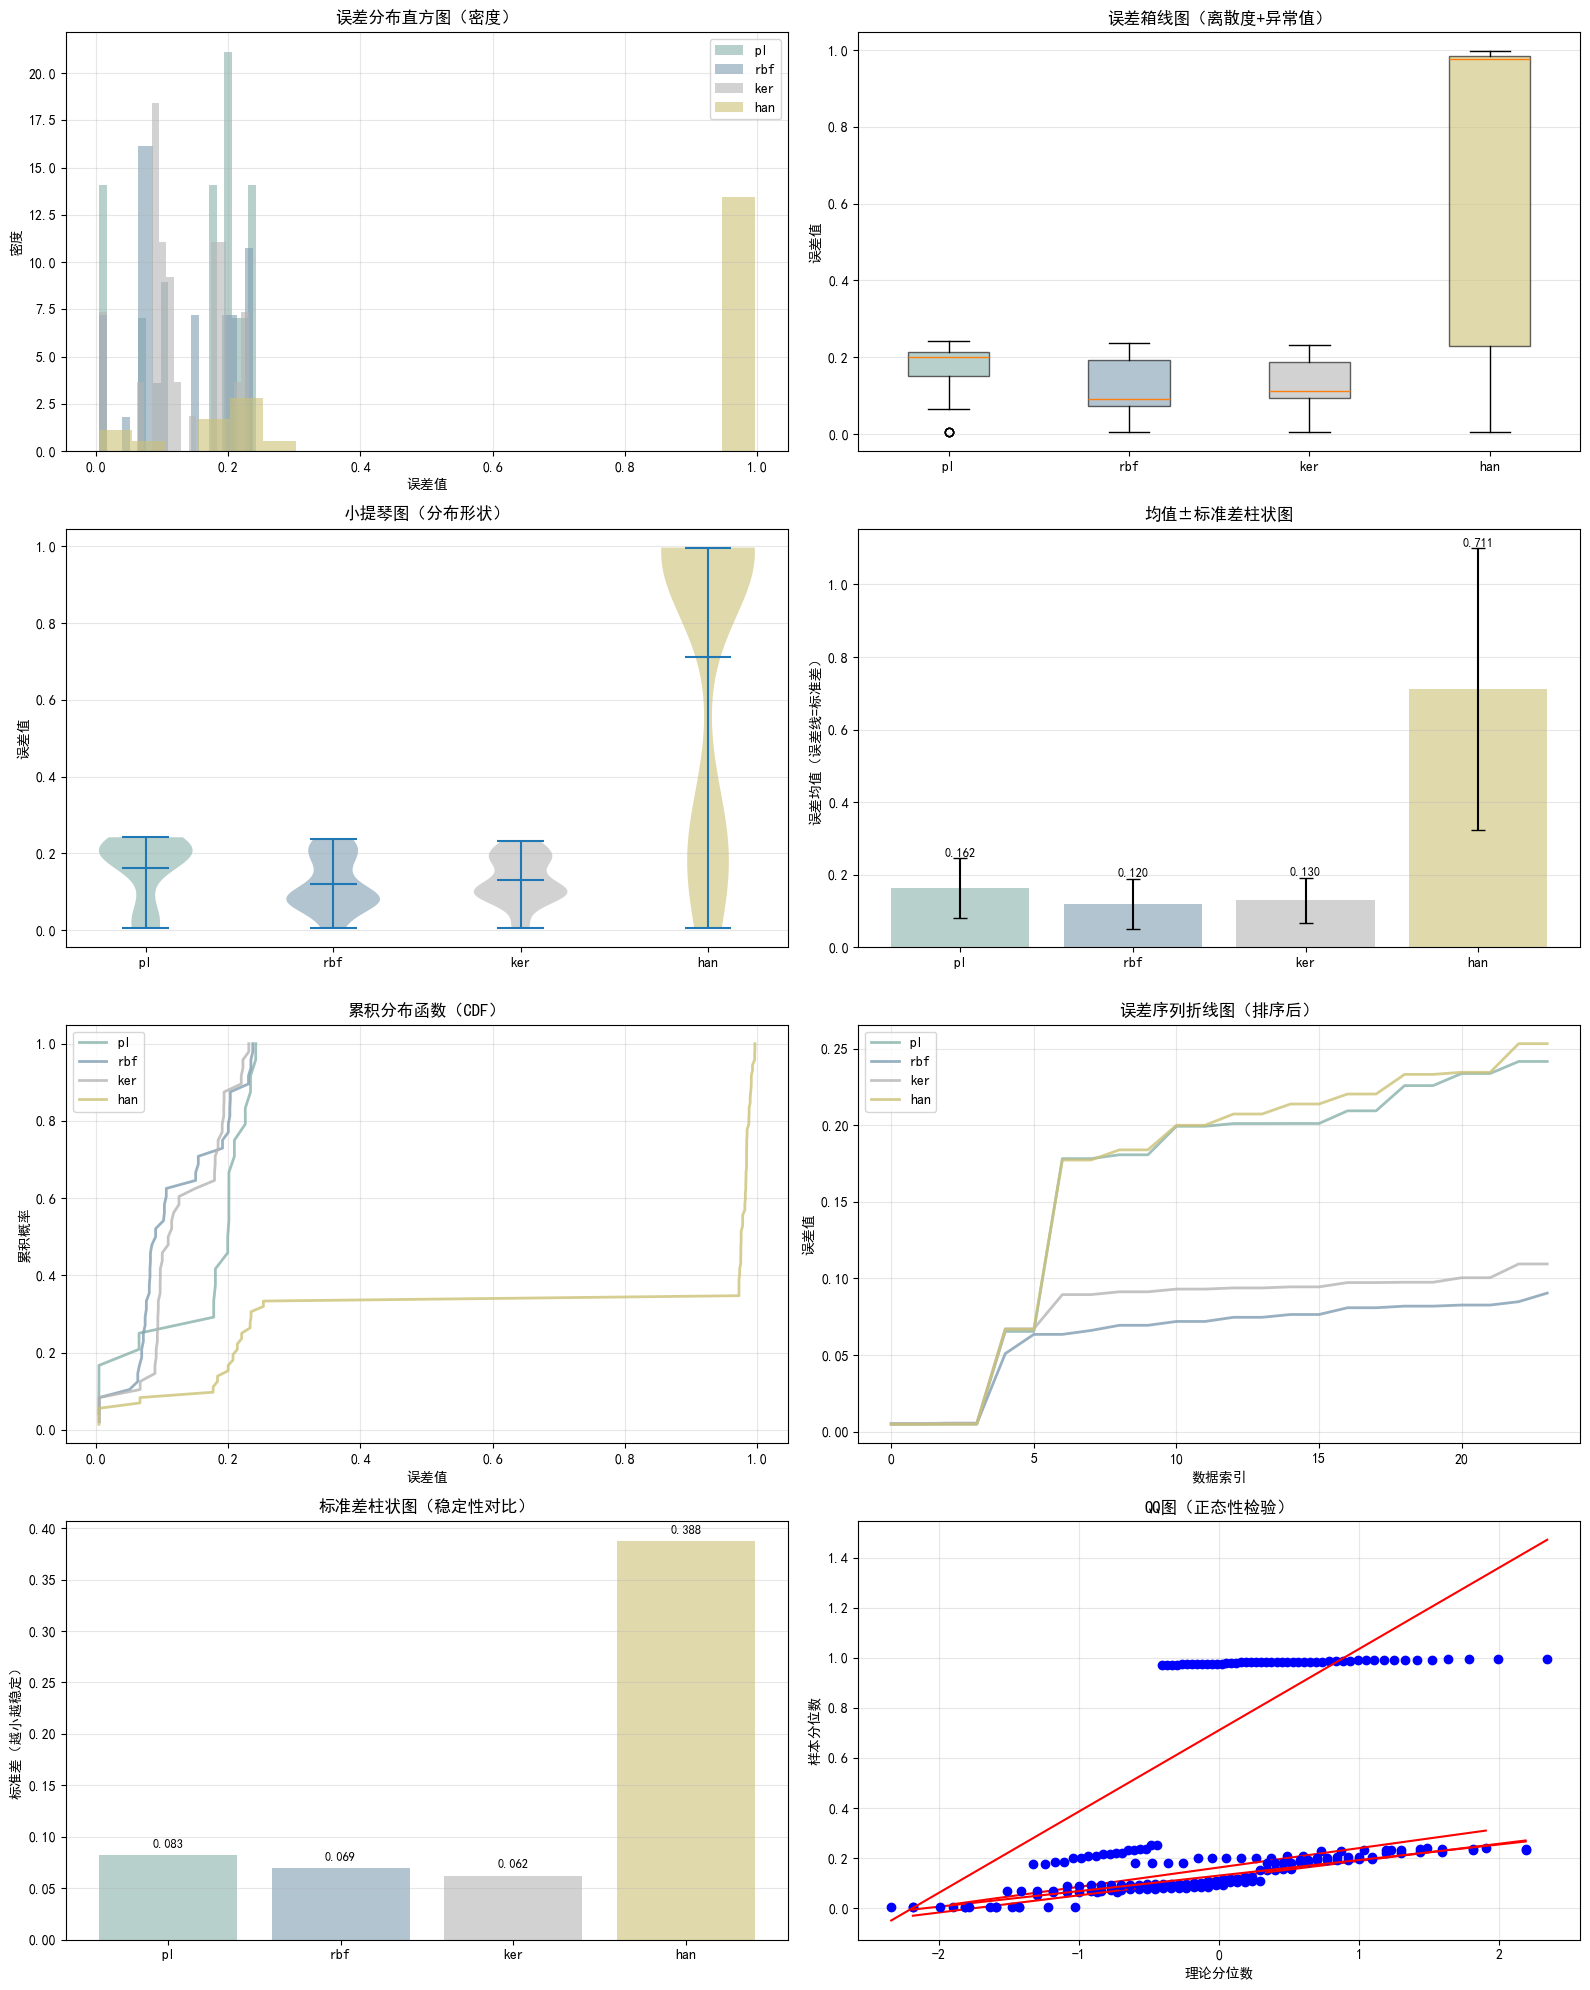

In [66]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 4行2列布局，共8张图

# 图1：直方图（误差分布密度）
for i, (method, data) in enumerate(res_dict.items()):
    axes[0,0].hist(data, alpha=0.6, bins=20, label=method, color=colors[i], density=True)
axes[0,0].set_title("误差分布直方图（密度）", fontsize=12, fontweight='bold')
axes[0,0].set_xlabel("误差值")
axes[0,0].set_ylabel("密度")
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 图2：箱线图（离散度+异常值）
box_data = [res_dict[method] for method in methods]
bp = axes[0,1].boxplot(box_data, labels=methods, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0,1].set_title("误差箱线图（离散度+异常值）", fontsize=12, fontweight='bold')
axes[0,1].set_ylabel("误差值")
axes[0,1].grid(alpha=0.3, axis='y')

# 图3：小提琴图（分布形状+概率密度）
violin_parts = axes[1,0].violinplot(box_data, positions=range(len(methods)), showmeans=True)
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.6)
axes[1,0].set_xticks(range(len(methods)))
axes[1,0].set_xticklabels(methods)
axes[1,0].set_title("小提琴图（分布形状）", fontsize=12, fontweight='bold')
axes[1,0].set_ylabel("误差值")
axes[1,0].grid(alpha=0.3, axis='y')

# 图4：均值±标准差柱状图（整体性能对比）
means = [res_dict[method].mean() for method in methods]
stds = [res_dict[method].std() for method in methods]
x_pos = range(len(methods))
bars = axes[1,1].bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.6)
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(methods)
axes[1,1].set_title("均值±标准差柱状图", fontsize=12, fontweight='bold')
axes[1,1].set_ylabel("误差均值（误差线=标准差）")
axes[1,1].grid(alpha=0.3, axis='y')
# 在柱子上标注均值
for i, (bar, mean) in enumerate(zip(bars, means)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i], 
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

# 图5：累积分布函数（CDF）
for i, (method, data) in enumerate(res_dict.items()):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    axes[2,0].plot(sorted_data, cdf, label=method, color=colors[i], linewidth=2)
axes[2,0].set_title("累积分布函数（CDF）", fontsize=12, fontweight='bold')
axes[2,0].set_xlabel("误差值")
axes[2,0].set_ylabel("累积概率")
axes[2,0].legend()
axes[2,0].grid(alpha=0.3)

# 图6：误差序列折线图（按索引排序，看波动）
for i, (method, data) in enumerate(res_dict.items()):
    # 统一长度（取最短数据的长度，避免维度不匹配）
    min_len = min([len(v) for v in res_dict.values()])
    sorted_data = np.sort(data)[:min_len]
    axes[2,1].plot(range(min_len), sorted_data, label=method, color=colors[i], alpha=0.8, linewidth=2)
axes[2,1].set_title("误差序列折线图（排序后）", fontsize=12, fontweight='bold')
axes[2,1].set_xlabel("数据索引")
axes[2,1].set_ylabel("误差值")
axes[2,1].legend()
axes[2,1].grid(alpha=0.3)

# 图7：标准差对比柱状图（稳定性对比）
std_bars = axes[3,0].bar(x_pos, stds, color=colors, alpha=0.6)
axes[3,0].set_xticks(x_pos)
axes[3,0].set_xticklabels(methods)
axes[3,0].set_title("标准差柱状图（稳定性对比）", fontsize=12, fontweight='bold')
axes[3,0].set_ylabel("标准差（越小越稳定）")
axes[3,0].grid(alpha=0.3, axis='y')
# 标注标准差
for bar, std in zip(std_bars, stds):
    axes[3,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{std:.3f}', ha='center', va='bottom', fontsize=9)

# 图8：QQ图（检验正态分布）
for i, (method, data) in enumerate(res_dict.items()):
    stats.probplot(data, dist="norm", plot=axes[3,1])
axes[3,1].set_title("QQ图（正态性检验）", fontsize=12, fontweight='bold')
axes[3,1].set_xlabel("理论分位数")
axes[3,1].set_ylabel("样本分位数")
axes[3,1].grid(alpha=0.3)

# 调整布局，保存图片
plt.tight_layout()
plt.savefig("误差数据分析图表kura全.png", dpi=300, bbox_inches='tight')
plt.show()


In [67]:
print("\n=== 两两方法差异显著性检验（独立样本t检验）===")
print("检验目的：比较两组方法的误差均值是否存在显著差异")
print("检验标准：P<0.05 → 存在显著差异；P≥0.05 → 无显著差异\n")

# 生成所有两两组合（不重复）
method_pairs = list(combinations(methods, 2))
significance_count = 0  # 统计显著差异的组数

for i, (method1, method2) in enumerate(method_pairs, 1):
    data1 = res_dict[method1]
    data2 = res_dict[method2]
    
    # 第一步：检验方差齐性（Levene检验）
    levene_stat, levene_p = stats.levene(data1, data2)
    equal_var = levene_p >= 0.05  # 方差齐性（P≥0.05）则equal_var=True
    
    # 第二步：独立样本t检验（根据方差齐性选择是否校正）
    t_stat, t_p = stats.ttest_ind(data1, data2, equal_var=equal_var)
    
    # 计算均值差异（method1 - method2）
    mean_diff = data1.mean() - data2.mean()
    mean_diff_dir = "大于" if mean_diff > 0 else "小于"
    
    # 输出结果
    print(f"[{i}] {method1} vs {method2}：")
    print(f"  方差齐性检验：Levene统计量={levene_stat:.4f}，P值={levene_p:.4f} → {'方差齐性' if equal_var else '方差不齐'}")
    print(f"  t检验：t统计量={t_stat:.4f}，P值={t_p:.4f}")
    print(f"  均值差异：{method1}均值（{data1.mean():.4f}）{mean_diff_dir} {method2}均值（{data2.mean():.4f}），差值={abs(mean_diff):.4f}")
    print(f"  结论：{'存在显著差异' if t_p < 0.05 else '无显著差异'}（P{'<' if t_p < 0.05 else '≥'}0.05）")
    print()
    
    if t_p < 0.05:
        significance_count += 1

# 汇总统计
print(f"=== 检验汇总 ===")
print(f"总对比组数：{len(method_pairs)} 组")
print(f"存在显著差异的组数：{significance_count} 组")
print(f"无显著差异的组数：{len(method_pairs) - significance_count} 组")


=== 两两方法差异显著性检验（独立样本t检验）===
检验目的：比较两组方法的误差均值是否存在显著差异
检验标准：P<0.05 → 存在显著差异；P≥0.05 → 无显著差异

[1] pl vs rbf：
  方差齐性检验：Levene统计量=0.0002，P值=0.9889 → 方差齐性
  t检验：t统计量=2.2718，P值=0.0262
  均值差异：pl均值（0.1622）大于 rbf均值（0.1196），差值=0.0426
  结论：存在显著差异（P<0.05）

[2] pl vs ker：
  方差齐性检验：Levene统计量=0.1762，P值=0.6760 → 方差齐性
  t检验：t统计量=1.8351，P值=0.0707
  均值差异：pl均值（0.1622）大于 ker均值（0.1298），差值=0.0324
  结论：无显著差异（P≥0.05）

[3] pl vs han：
  方差齐性检验：Levene统计量=7.6531，P值=0.0068 → 方差不齐
  t检验：t统计量=-11.1622，P值=0.0000
  均值差异：pl均值（0.1622）小于 han均值（0.7109），差值=0.5487
  结论：存在显著差异（P<0.05）

[4] rbf vs ker：
  方差齐性检验：Levene统计量=0.3337，P值=0.5648 → 方差齐性
  t检验：t统计量=-0.7526，P值=0.4536
  均值差异：rbf均值（0.1196）小于 ker均值（0.1298），差值=0.0102
  结论：无显著差异（P≥0.05）

[5] rbf vs han：
  方差齐性检验：Levene统计量=15.4039，P值=0.0001 → 方差不齐
  t检验：t统计量=-12.5433，P值=0.0000
  均值差异：rbf均值（0.1196）小于 han均值（0.7109），差值=0.5913
  结论：存在显著差异（P<0.05）

[6] ker vs han：
  方差齐性检验：Levene统计量=16.2344，P值=0.0001 → 方差不齐
  t检验：t统计量=-12.3823，P值=0.0000
  均值差异：ker均值（0.1298）小于 han均值（0.7109），差值=0.5811

## 残差总分析2

In [68]:
res_dict2 = {}
methods2 = ["pl", "rbf", "ker"]
res_dict2["pl"] = residualspl
res_dict2["rbf"] = residualsrbf
res_dict2["ker"] = residualsker

print("数据存储完成，字典结构：")
for method, data in res_dict2.items():
    print(f"{method}: 共{len(data)}个误差值，均值={data.mean():.4f}，标准差={data.std():.4f}")

数据存储完成，字典结构：
pl: 共24个误差值，均值=0.1622，标准差=0.0825
rbf: 共48个误差值，均值=0.1196，标准差=0.0693
ker: 共48个误差值，均值=0.1298，标准差=0.0622


In [69]:
print("\n=== 详细统计分析 ===")
stats_df2 = pd.DataFrame()
for method, data in res_dict2.items():
    stats_df2[method] = [
        len(data),                  # 数据量
        data.mean(),                # 均值（误差大小）
        data.std(),                 # 标准差（稳定性）
        data.min(),                 # 最小
        data.max(),                 # 最大
        np.median(data),            # 中位数（抗异常值）
        stats.skew(data),           # 偏度（分布对称性）
        stats.kurtosis(data)        # 峰度（分布陡峭程度）
    ]
stats_df2.index = ["数据量", "均值", "标准差", "最小值", "最大值", "中位数", "偏度", "峰度"]
print(stats_df2.round(4))


=== 详细统计分析 ===
          pl      rbf      ker
数据量  24.0000  48.0000  48.0000
均值    0.1622   0.1196   0.1298
标准差   0.0825   0.0693   0.0622
最小值   0.0047   0.0052   0.0051
最大值   0.2417   0.2373   0.2313
中位数   0.2003   0.0904   0.1121
偏度   -1.0826   0.3269  -0.1274
峰度   -0.4635  -1.0490  -0.7048


In [70]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False    # 支持负号
colors = plt.cm.Set3(np.linspace(0, 1, len(methods))) * 0.6 + 0.2  # 亮度调整（0-1区间）

C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_10844\3028155030.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[0,1].boxplot(box_data2, labels=methods2, patch_artist=True)


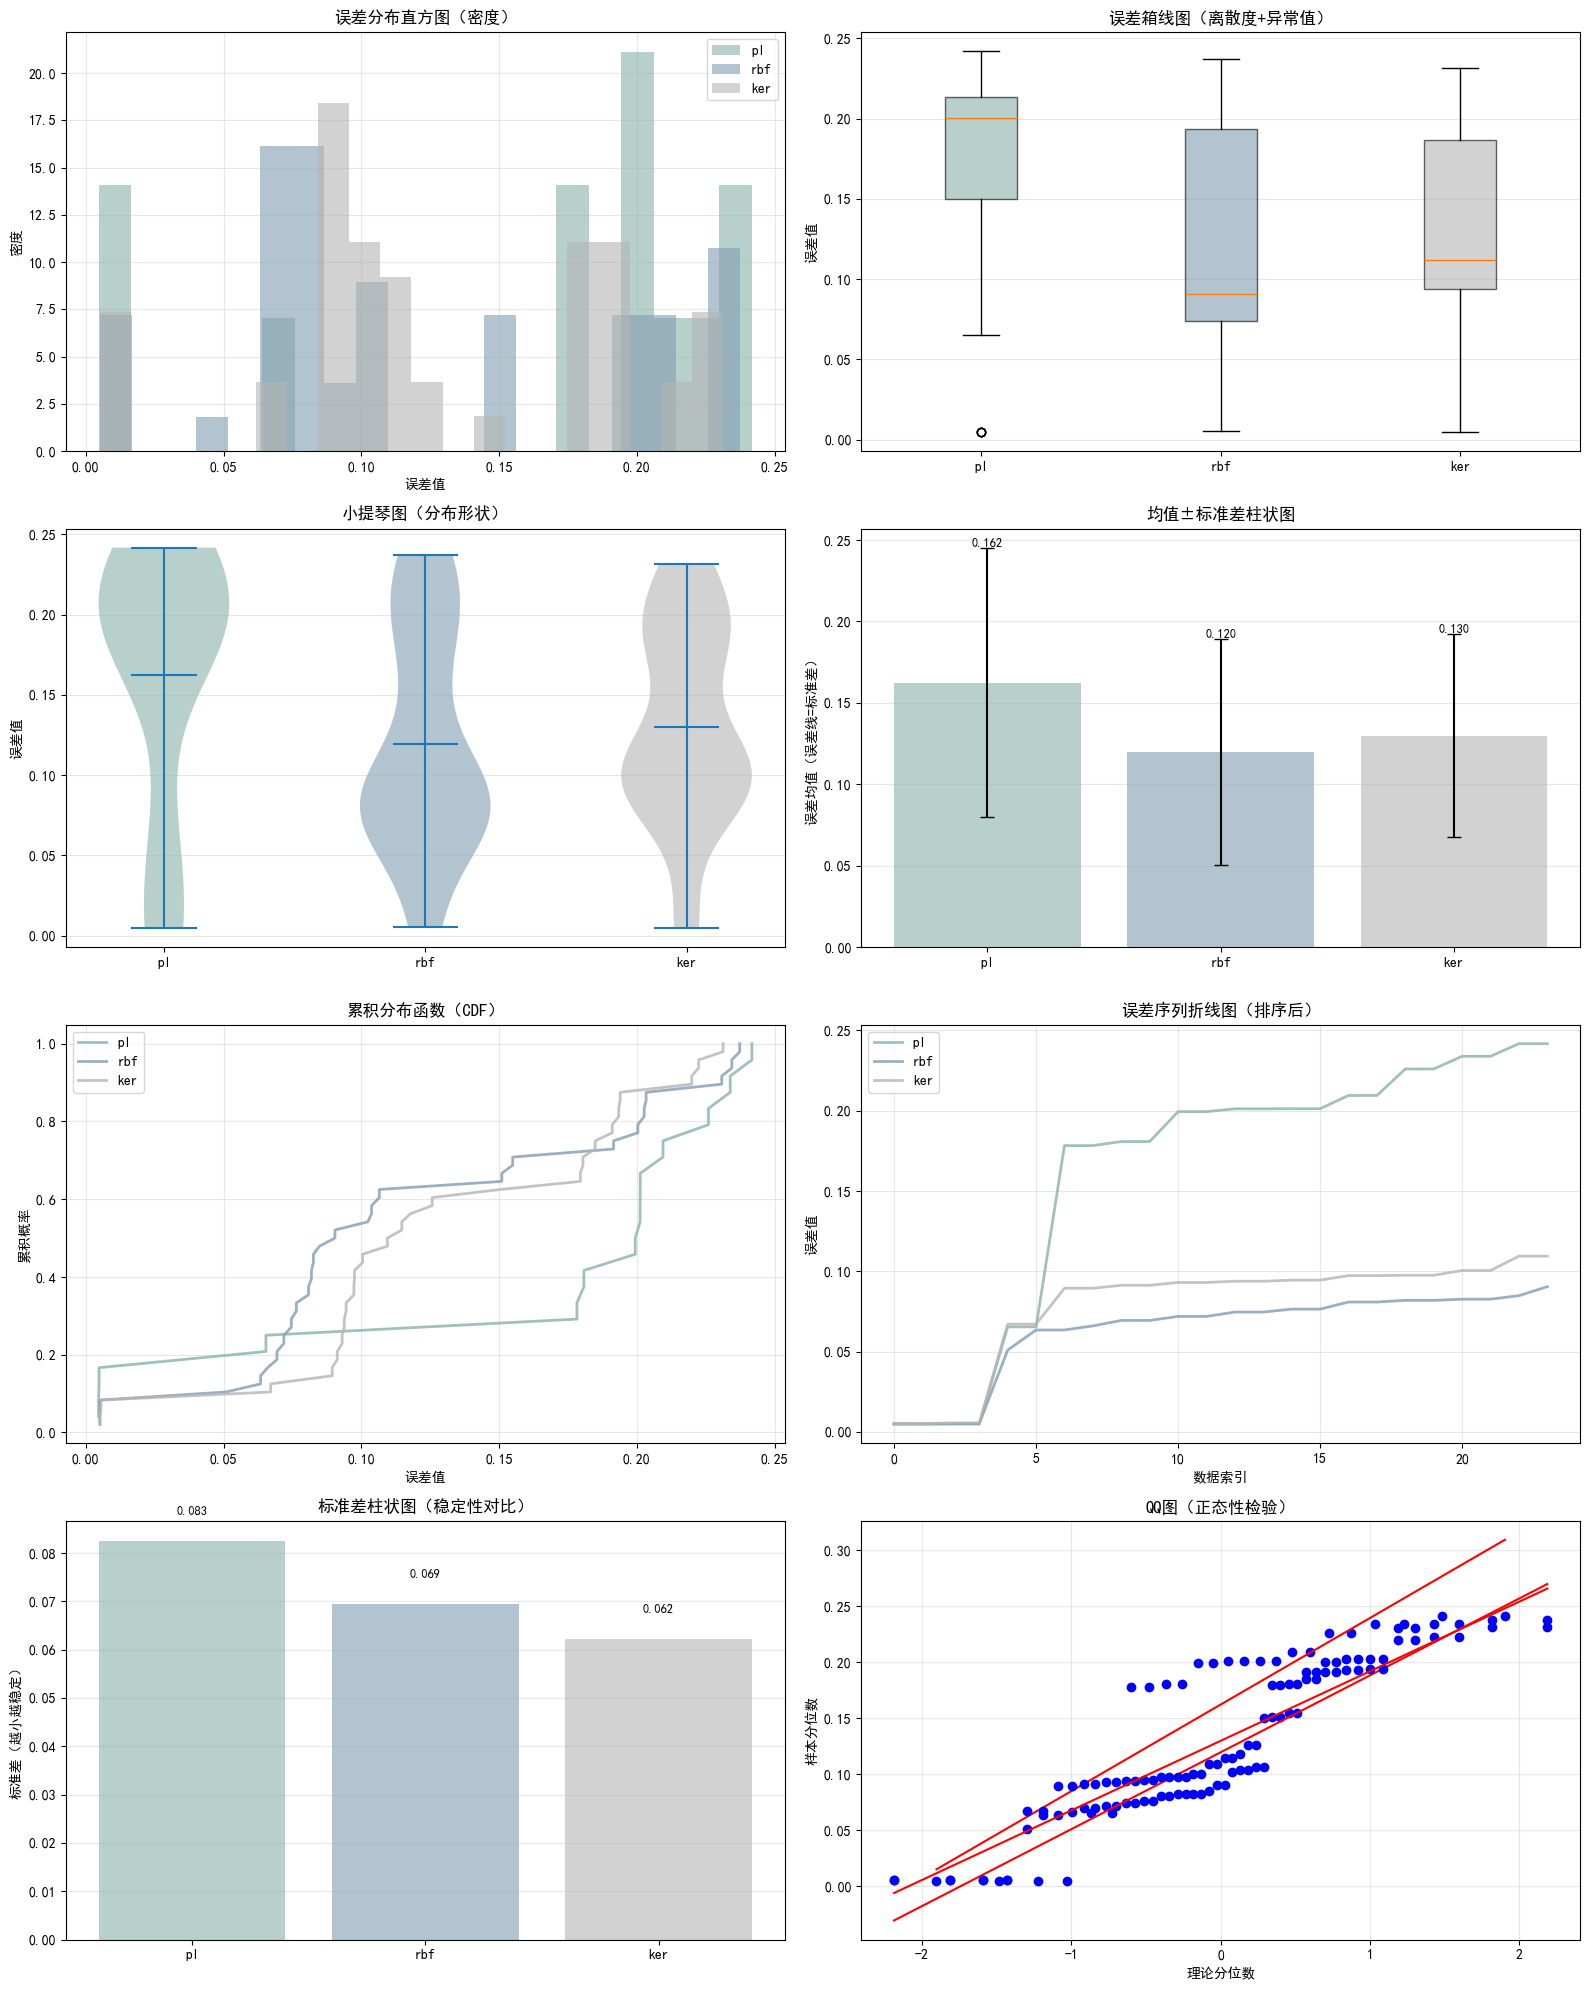

In [71]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 4行2列布局，共8张图

# 图1：直方图（误差分布密度）
for i, (method, data) in enumerate(res_dict2.items()):
    axes[0,0].hist(data, alpha=0.6, bins=20, label=method, color=colors[i], density=True)
axes[0,0].set_title("误差分布直方图（密度）", fontsize=12, fontweight='bold')
axes[0,0].set_xlabel("误差值")
axes[0,0].set_ylabel("密度")
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 图2：箱线图（离散度+异常值）
box_data2 = [res_dict2[method] for method in methods2]
bp2 = axes[0,1].boxplot(box_data2, labels=methods2, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0,1].set_title("误差箱线图（离散度+异常值）", fontsize=12, fontweight='bold')
axes[0,1].set_ylabel("误差值")
axes[0,1].grid(alpha=0.3, axis='y')

# 图3：小提琴图（分布形状+概率密度）
violin_parts2 = axes[1,0].violinplot(box_data2, positions=range(len(methods2)), showmeans=True)
for i, pc in enumerate(violin_parts2['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.6)
axes[1,0].set_xticks(range(len(methods2)))
axes[1,0].set_xticklabels(methods2)
axes[1,0].set_title("小提琴图（分布形状）", fontsize=12, fontweight='bold')
axes[1,0].set_ylabel("误差值")
axes[1,0].grid(alpha=0.3, axis='y')

# 图4：均值±标准差柱状图（整体性能对比）
means2 = [res_dict2[method].mean() for method in methods2]
stds2 = [res_dict2[method].std() for method in methods2]
x_pos2 = range(len(methods2))
bars2 = axes[1,1].bar(x_pos2, means2, yerr=stds2, capsize=5, color=colors, alpha=0.6)
axes[1,1].set_xticks(x_pos2)
axes[1,1].set_xticklabels(methods2)
axes[1,1].set_title("均值±标准差柱状图", fontsize=12, fontweight='bold')
axes[1,1].set_ylabel("误差均值（误差线=标准差）")
axes[1,1].grid(alpha=0.3, axis='y')
# 在柱子上标注均值
for i, (bar, mean) in enumerate(zip(bars2, means2)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds2[i], 
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

# 图5：累积分布函数（CDF）
for i, (method, data) in enumerate(res_dict2.items()):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    axes[2,0].plot(sorted_data, cdf, label=method, color=colors[i], linewidth=2)
axes[2,0].set_title("累积分布函数（CDF）", fontsize=12, fontweight='bold')
axes[2,0].set_xlabel("误差值")
axes[2,0].set_ylabel("累积概率")
axes[2,0].legend()
axes[2,0].grid(alpha=0.3)

# 图6：误差序列折线图（按索引排序，看波动）
for i, (method, data) in enumerate(res_dict2.items()):
    # 统一长度（取最短数据的长度，避免维度不匹配）
    min_len = min([len(v) for v in res_dict2.values()])
    sorted_data = np.sort(data)[:min_len]
    axes[2,1].plot(range(min_len), sorted_data, label=method, color=colors[i], alpha=0.8, linewidth=2)
axes[2,1].set_title("误差序列折线图（排序后）", fontsize=12, fontweight='bold')
axes[2,1].set_xlabel("数据索引")
axes[2,1].set_ylabel("误差值")
axes[2,1].legend()
axes[2,1].grid(alpha=0.3)

# 图7：标准差对比柱状图（稳定性对比）
std_bars2 = axes[3,0].bar(x_pos2, stds2, color=colors, alpha=0.6)
axes[3,0].set_xticks(x_pos2)
axes[3,0].set_xticklabels(methods2)
axes[3,0].set_title("标准差柱状图（稳定性对比）", fontsize=12, fontweight='bold')
axes[3,0].set_ylabel("标准差（越小越稳定）")
axes[3,0].grid(alpha=0.3, axis='y')
# 标注标准差
for bar, std in zip(std_bars2, stds2):
    axes[3,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{std:.3f}', ha='center', va='bottom', fontsize=9)

# 图8：QQ图（检验正态分布）
for i, (method, data) in enumerate(res_dict2.items()):
    stats.probplot(data, dist="norm", plot=axes[3,1])
axes[3,1].set_title("QQ图（正态性检验）", fontsize=12, fontweight='bold')
axes[3,1].set_xlabel("理论分位数")
axes[3,1].set_ylabel("样本分位数")
axes[3,1].grid(alpha=0.3)

# 调整布局，保存图片
plt.tight_layout()
plt.savefig("误差数据分析图表kura_多项式_径向基_核.png", dpi=300, bbox_inches='tight')
plt.show()


In [72]:
print("\n=== 两两方法差异显著性检验（独立样本t检验）===")
print("检验目的：比较两组方法的误差均值是否存在显著差异")
print("检验标准：P<0.05 → 存在显著差异；P≥0.05 → 无显著差异\n")

# 生成所有两两组合（不重复）
method_pairs2 = list(combinations(methods2, 2))
significance_count2 = 0  # 统计显著差异的组数

for i, (method1, method2) in enumerate(method_pairs2, 1):
    data1 = res_dict[method1]
    data2 = res_dict[method2]
    
    # 第一步：检验方差齐性（Levene检验）
    levene_stat, levene_p = stats.levene(data1, data2)
    equal_var = levene_p >= 0.05  # 方差齐性（P≥0.05）则equal_var=True
    
    # 第二步：独立样本t检验（根据方差齐性选择是否校正）
    t_stat, t_p = stats.ttest_ind(data1, data2, equal_var=equal_var)
    
    # 计算均值差异（method1 - method2）
    mean_diff = data1.mean() - data2.mean()
    mean_diff_dir = "大于" if mean_diff > 0 else "小于"
    
    # 输出结果
    print(f"[{i}] {method1} vs {method2}：")
    print(f"  方差齐性检验：Levene统计量={levene_stat:.4f}，P值={levene_p:.4f} → {'方差齐性' if equal_var else '方差不齐'}")
    print(f"  t检验：t统计量={t_stat:.4f}，P值={t_p:.4f}")
    print(f"  均值差异：{method1}均值（{data1.mean():.4f}）{mean_diff_dir} {method2}均值（{data2.mean():.4f}），差值={abs(mean_diff):.4f}")
    print(f"  结论：{'存在显著差异' if t_p < 0.05 else '无显著差异'}（P{'<' if t_p < 0.05 else '≥'}0.05）")
    print()
    
    if t_p < 0.05:
        significance_count2 += 1

# 汇总统计
print(f"=== 检验汇总 ===")
print(f"总对比组数：{len(method_pairs2)} 组")
print(f"存在显著差异的组数：{significance_count2} 组")
print(f"无显著差异的组数：{len(method_pairs2) - significance_count2} 组")


=== 两两方法差异显著性检验（独立样本t检验）===
检验目的：比较两组方法的误差均值是否存在显著差异
检验标准：P<0.05 → 存在显著差异；P≥0.05 → 无显著差异

[1] pl vs rbf：
  方差齐性检验：Levene统计量=0.0002，P值=0.9889 → 方差齐性
  t检验：t统计量=2.2718，P值=0.0262
  均值差异：pl均值（0.1622）大于 rbf均值（0.1196），差值=0.0426
  结论：存在显著差异（P<0.05）

[2] pl vs ker：
  方差齐性检验：Levene统计量=0.1762，P值=0.6760 → 方差齐性
  t检验：t统计量=1.8351，P值=0.0707
  均值差异：pl均值（0.1622）大于 ker均值（0.1298），差值=0.0324
  结论：无显著差异（P≥0.05）

[3] rbf vs ker：
  方差齐性检验：Levene统计量=0.3337，P值=0.5648 → 方差齐性
  t检验：t统计量=-0.7526，P值=0.4536
  均值差异：rbf均值（0.1196）小于 ker均值（0.1298），差值=0.0102
  结论：无显著差异（P≥0.05）

=== 检验汇总 ===
总对比组数：3 组
存在显著差异的组数：1 组
无显著差异的组数：2 组
